Wesley McGowan    
Zachary Rosenbaum  
Ruben Pena   
Machine Learning  CS 5841    
Classification Project 2   

In [0]:
# Import required packages
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf                                                             
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
#from keras.utils.np_utils import to_categorical

In [0]:
# Check installed versions of tf and keras
print(tf.__version__)
print(keras.__version__)
# Set matplotlib figsize for notebook
plt.rcParams['figure.figsize'] = (10,10)
# Set random seed generator
random.seed(0)

1.15.0
2.2.4-tf


In [0]:
# Import dataset from tensorflow datasets
dataset = tf.keras.datasets.mnist
print(type(dataset))

<class 'tensorflow.python.util.module_wrapper.TFModuleWrapper'>


In [0]:
# Load data as np arrays and rename data using tf.keras.datasets function
(x_train,y_train),(x_test,y_test) = dataset.load_data()
print(type(x_train))

<class 'numpy.ndarray'>


In [0]:
# Each 28x28 image is flattened into a vector of length 784
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

In [0]:
# Check the shapes of train data
x_train.shape,y_train.shape

((60000, 784), (60000,))

In [0]:
# Check the shape of the test data
x_test.shape,y_test.shape

((10000, 784), (10000,))

# Part 1 
# MNIST with Naive Bayes

In [0]:
#Find how may times a number occurs
classes = np.unique(y_train) # e.g., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
digit_indices = []
for C in classes:
    indices = np.where(y_train == C)[0]
    print('The ' + str(C) + ' class occurs '+ str(len(indices))+ ' times' )
    digit_indices.append(indices)

The 0 class occurs 5923 times
The 1 class occurs 6742 times
The 2 class occurs 5958 times
The 3 class occurs 6131 times
The 4 class occurs 5842 times
The 5 class occurs 5421 times
The 6 class occurs 5918 times
The 7 class occurs 6265 times
The 8 class occurs 5851 times
The 9 class occurs 5949 times


Each feature has 10 different single variate guassian distributions assiocated with it. Each of these distributions will have 2 parameters to estimate, the mean and the standard deviation.  

The MLE estimators for these parameters are the sample mean and standard deviation of the data. Thus there will be 784x10 means, and 784x10 standard deviation parameters.

In [0]:
# Initialize means and stdevs lists as 10x784 full of zeros
means = np.zeros((10,784))
stds =  np.zeros((10,784))

In [0]:
for idx, indices in enumerate(digit_indices):
    means[idx] = np.mean(x_train[indices],axis=0)
    stds[idx]  = np.std(x_train[indices],axis=0) #ddof=0 because we choose MLE
stds += .0001 #add a small bias to avoid division by zero

In [0]:
# Classifier
a = (2*np.pi)**-.5 #normal constant
log_probs = np.zeros((len(x_test),len(classes)))
for i in range(len(x_test)):
    for C in classes:
        X = x_test[i] #
        u =  means[C] #0class
        sigma = stds[C]
        log_probs[i,C] = np.sum(np.log(a/sigma) - .5 * (((X - u)/sigma)**2))
y_pred = np.argmax(log_probs,axis=1)

### Naive Bayes Confusion Matrix

In [0]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6,7,8,9
0,841,0,1,4,2,5,37,1,52,37
1,1,1072,0,0,1,0,11,0,40,10
2,103,15,182,96,5,4,297,4,301,25
3,49,27,4,268,1,2,68,7,464,120
4,29,2,4,4,110,5,68,7,233,520
5,64,19,1,17,2,27,41,2,608,111
6,13,8,3,1,1,4,899,0,28,1
7,0,11,2,9,4,1,6,220,56,719
8,12,58,3,6,1,11,13,3,622,245
9,4,6,3,6,0,0,1,9,17,963


### Digit Accuracy

In [0]:
digit_acc = np.zeros(len(classes))
for C in classes:
    indices = np.where(y_test==C)[0]
    digit_acc[C]=np.mean(y_test[indices]==y_pred[indices])

In [0]:
pd.DataFrame(digit_acc).transpose()

,0,1,2,3,4,5,6,7,8,9
0,0.858163,0.944493,0.176357,0.265347,0.112016,0.030269,0.938413,0.214008,0.638604,0.95441


### Overall Accuracy

In [0]:
np.mean(y_pred==y_test)

0.5204

The accuracy for 5 is truly awful. According to the confusion matrix, its predictions are being absorbed into 8. Taking a closer look: 2,3,4,5 are all commonly mispredicted as 8. 

Similarily 4 and 7 get mispredicted as 9. 

Accuracies for 0, 1, 6, 9 are all comparitively good, but because of the extreme inaccuries for some digits pure Naive Gaussian isn't a good classifier with an overall accuracy of 52%.


## Sanity Check using sklearns GNB

In [0]:
skGNB = GaussianNB()
skGNB.fit(x_train, y_train)
sk_y_pred = skGNB.predict(x_test)

In [0]:
pd.DataFrame(confusion_matrix(y_test, sk_y_pred))

,0,1,2,3,4,5,6,7,8,9
0,870,0,3,5,2,5,31,1,35,28
1,0,1079,2,1,0,0,10,0,38,5
2,79,25,266,91,5,2,269,4,271,20
3,32,39,6,353,2,3,51,8,409,107
4,19,2,5,4,168,7,63,7,210,497
5,71,25,1,20,3,44,40,2,586,100
6,12,12,3,1,1,7,895,0,26,1
7,0,15,2,10,5,1,5,280,39,671
8,13,72,3,7,3,11,12,4,648,201
9,5,7,3,6,1,0,1,13,18,955


In [0]:
np.mean(y_test == sk_y_pred)

0.5558

Theirs has slightly better accuracy, but otherwise it shows very similar behavior, especially in the confusion matrix.

## For each of the 10 classes, show an image of the 784 conditional probabilities as a 28 x 28 image.

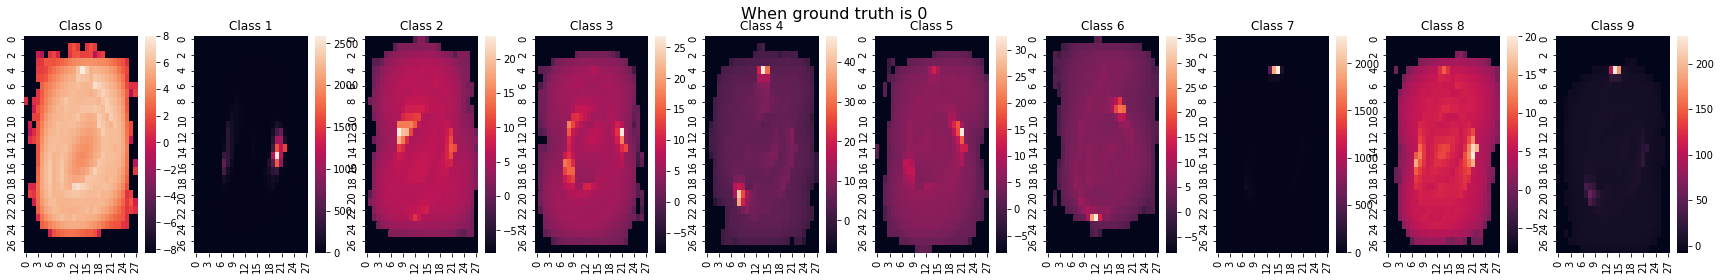

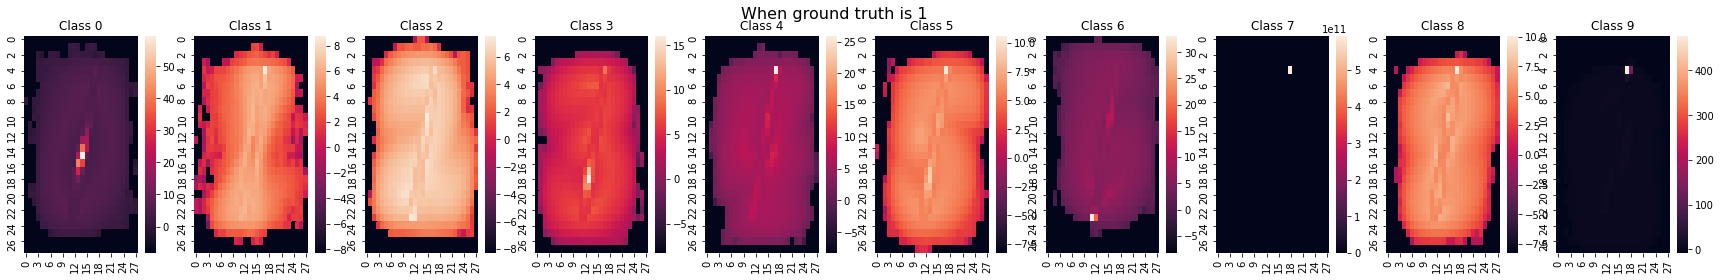

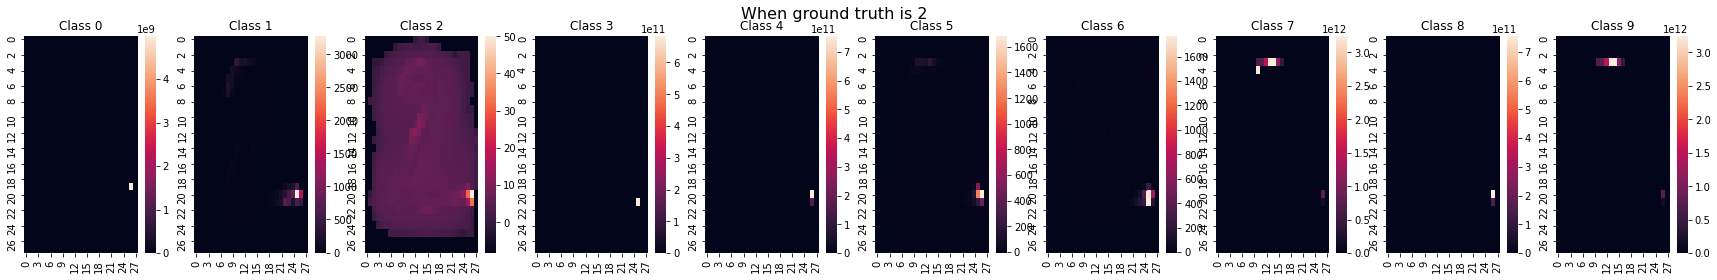

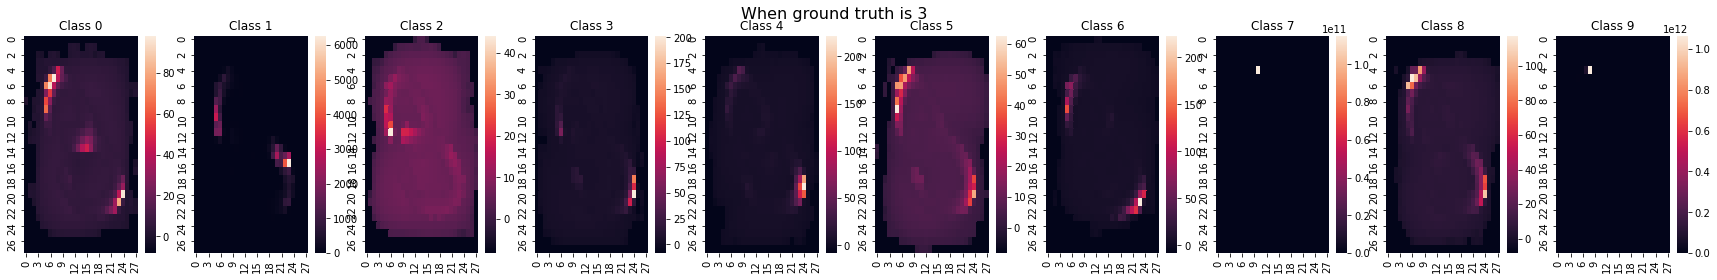

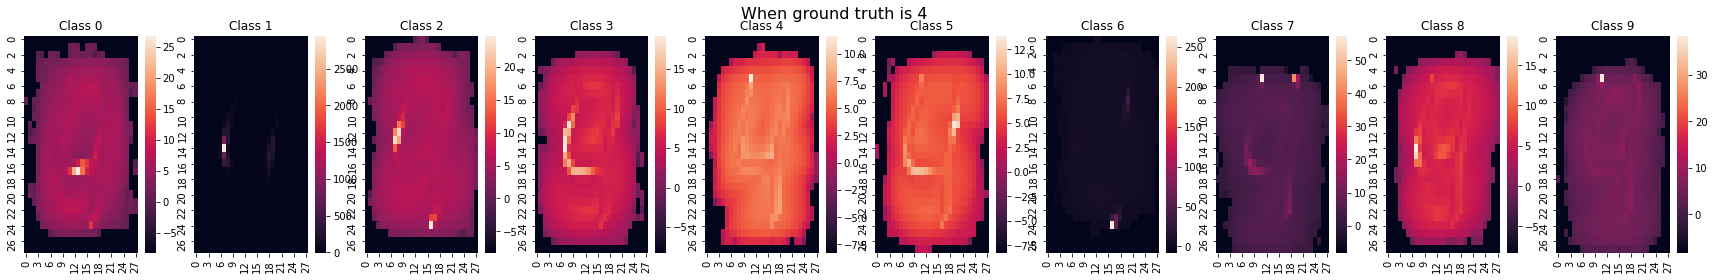

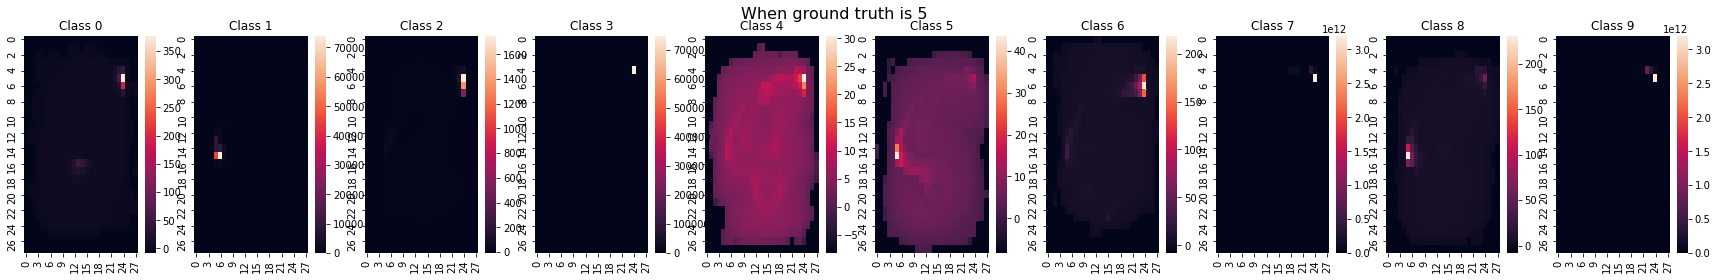

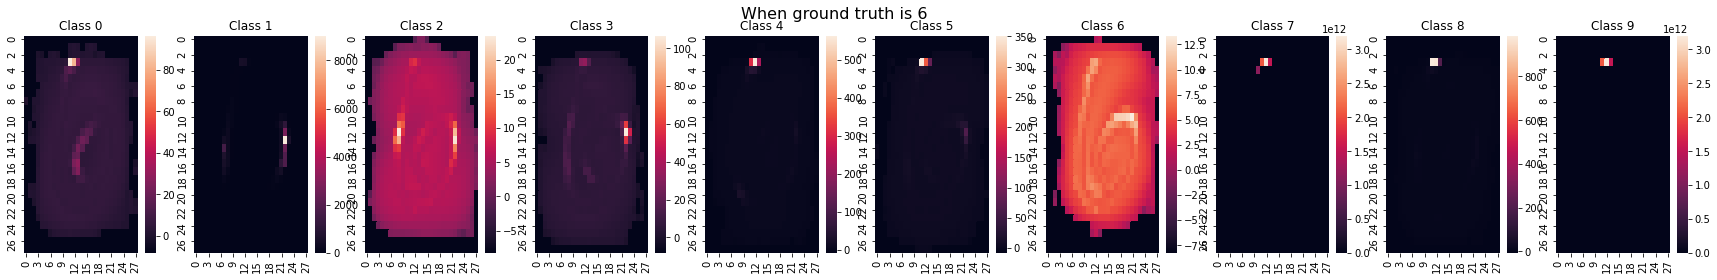

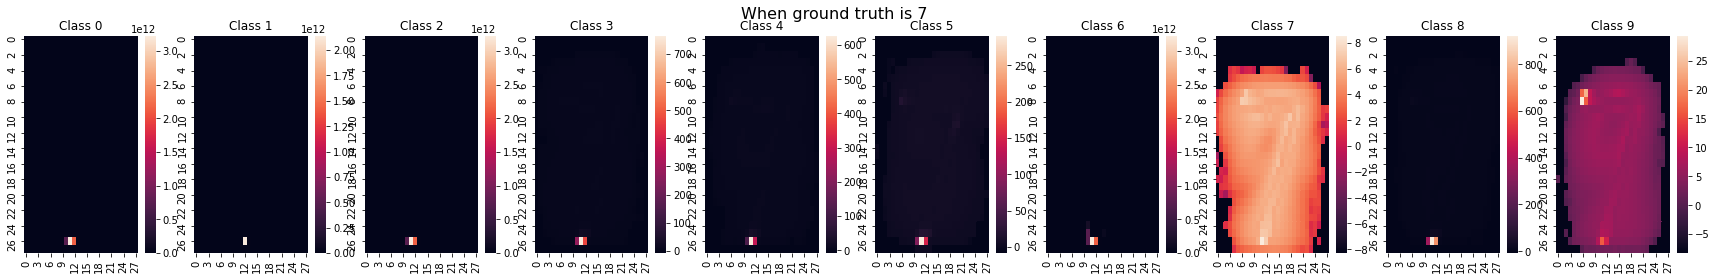

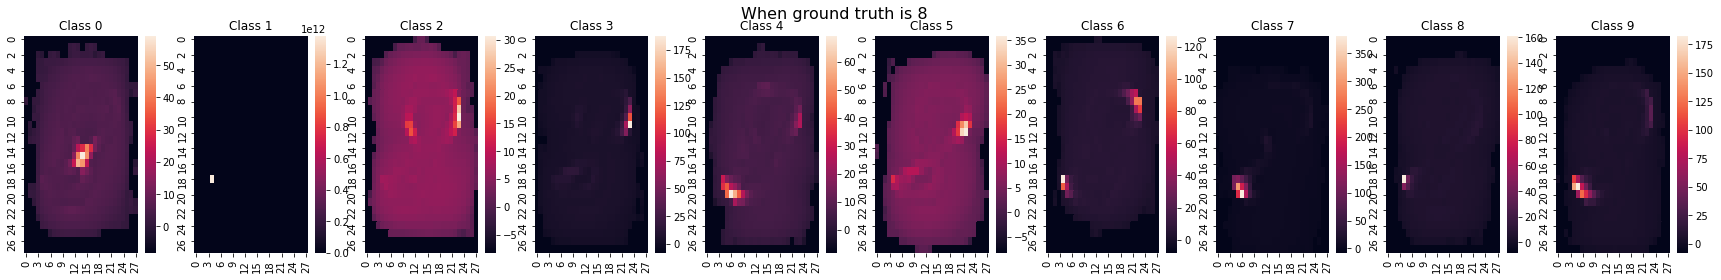

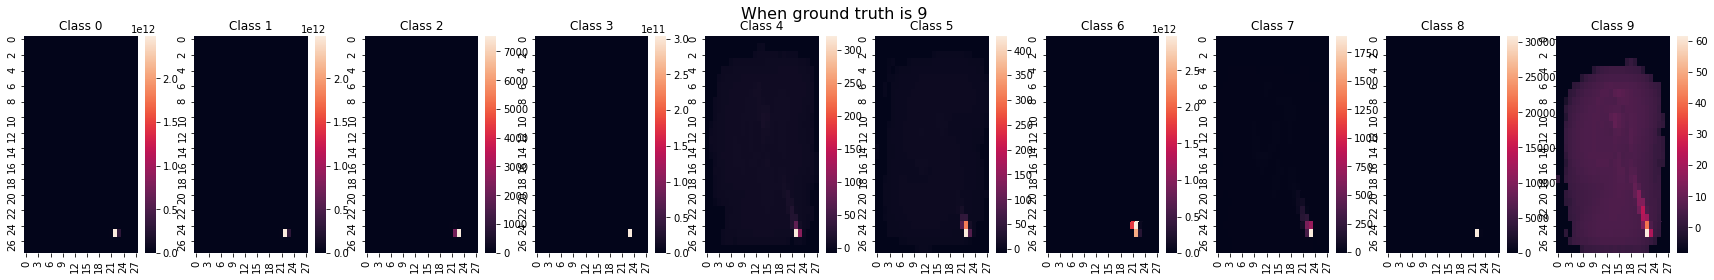

In [0]:
a = (2*np.pi)**-.5 **-.5 #normal constant

#find and store first index of each occurence
idx_each_digit = np.zeros(len(classes),dtype=np.int32) 
for C in classes:
    idx_each_digit[C] = np.where(y_test==C)[0][0]

#10x10 plotgird
for digit,idx in enumerate(idx_each_digit): #for each example digit
    fig,ax = plt.subplots(1,len(classes), figsize=(30,4), sharex=True)
    fig.suptitle("When ground truth is " + str(digit), fontsize=16)
    X = x_test[idx]
    for C in classes: #condition against each class
        plt.sca(ax[C])
        ax[C].set_title("Class " + str(C))
        u =  means[C]
        sigma = stds[C]
        probs = (np.log(a/sigma) - .5 * (((X - u)/sigma)**2)).reshape(28,28)
        sns.heatmap(-probs) #negative used here for a better color scheme
    plt.show()

# Do these images provide any insight into how this classifier works?

Above we can see the point measure (zero-width bin) of the log probability distributions for examples of each class, conditioned against each class.

Each row e.g.,'Ground Truth', is a single observation of a particular digit. Each graph within that row is 28x28 pixel heat map of that observation's log-prob against 1 of the 10 conditional distributions. That is, the class which is being conditioned on changes from left to right.

From the above pictures we can see how Naive Bayes look at each pixel as a feature, so yes these provide insight. In particular we can see how certain pixel-features light up when the the input pixel-intensity is high. Thus we can see that this approach would only work when the digit is centered and oreinted correctly. If the digit would shifted by even 5 pixels vertically or horizontally the classifier would likely fail, as they're looking for intesity in location specific pixels.

## For each of the 10 classes, show an image of the 784 conditional probabilities as a 28 x 28 image.

In [0]:
# Convert to list format for numpy calculations
X_train = np.array(x_train, dtype=np.float32).reshape((60000,784))
Y_train = np.array(y_train, dtype=np.int)
X_test = np.array(x_test, dtype=np.float32).reshape((10000,784))
Y_test = np.array(y_test, dtype=np.int)

In [0]:
c = []
for eachClass in range(0,10,1):
    c.append(X_train[Y_train == eachClass])  
numClasses = len(c)
c=np.array(c)

Conditional probability of class 0


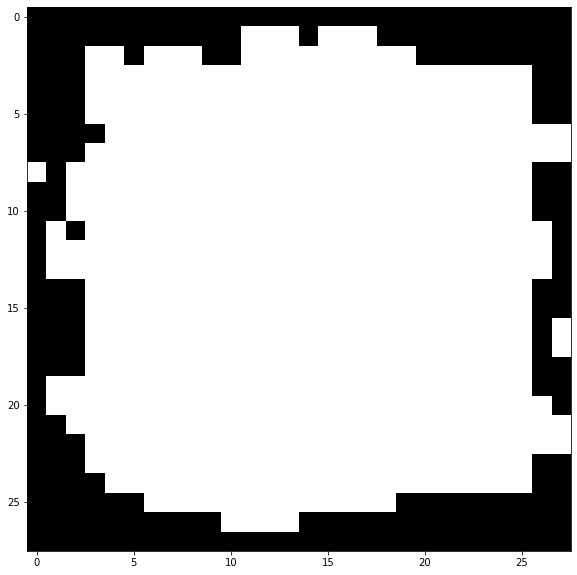

Conditional probability of class 1


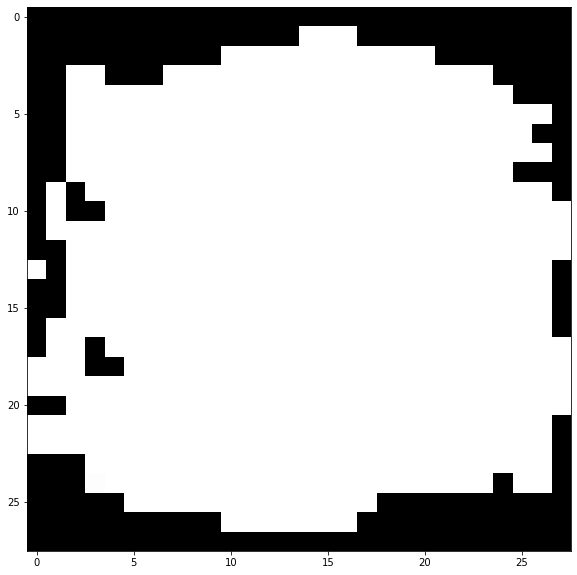

Conditional probability of class 2


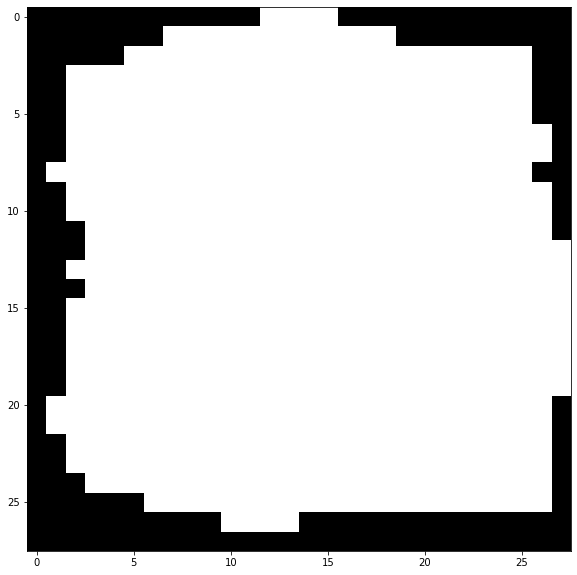

Conditional probability of class 3


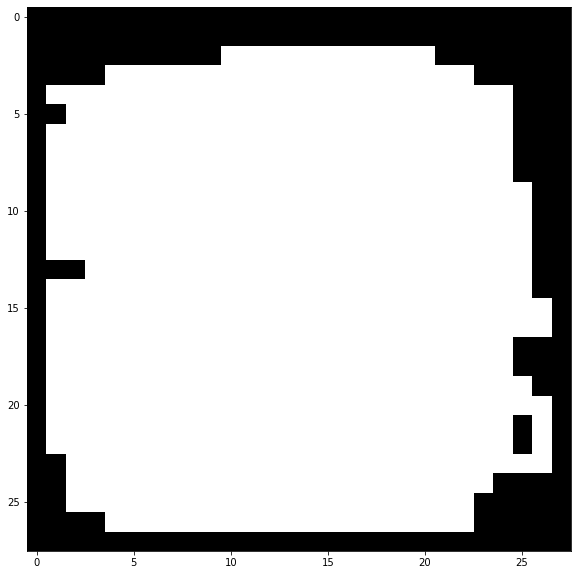

Conditional probability of class 4


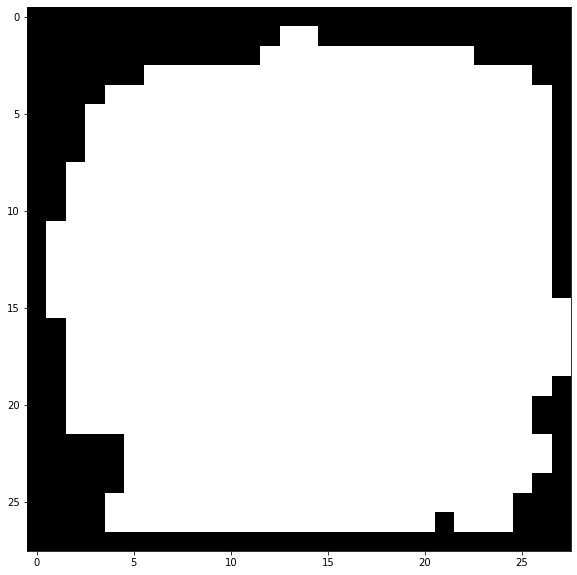

Conditional probability of class 5


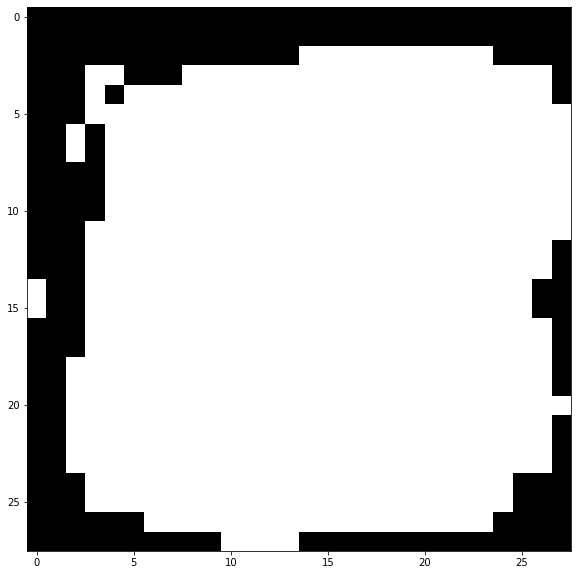

Conditional probability of class 6


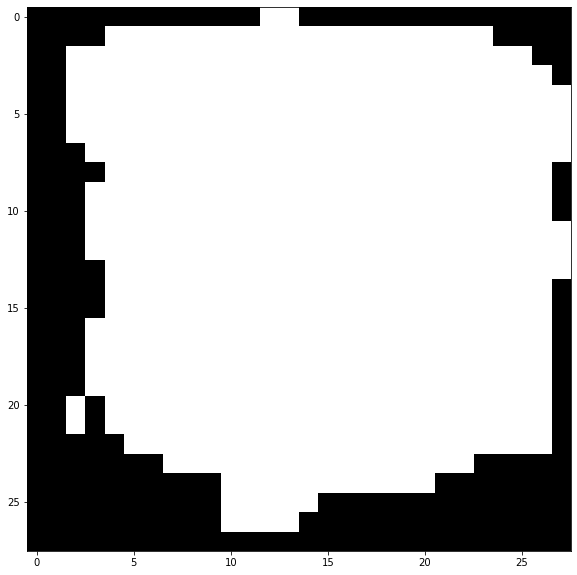

Conditional probability of class 7


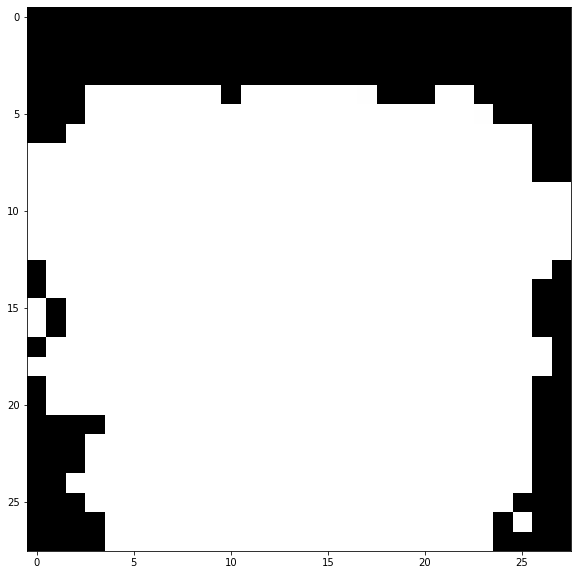

Conditional probability of class 8


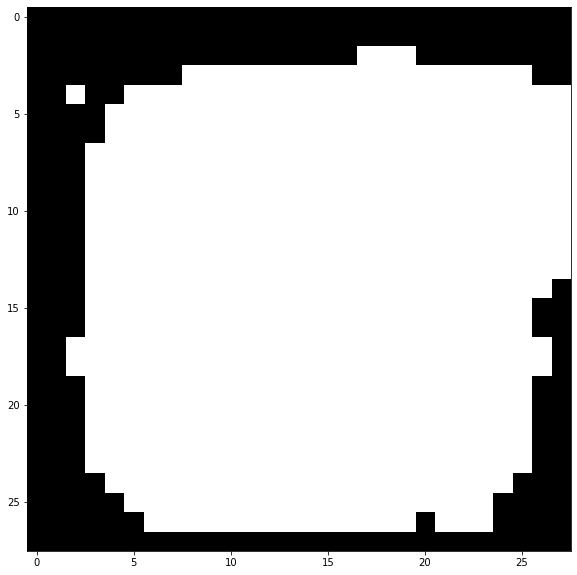

Conditional probability of class 9


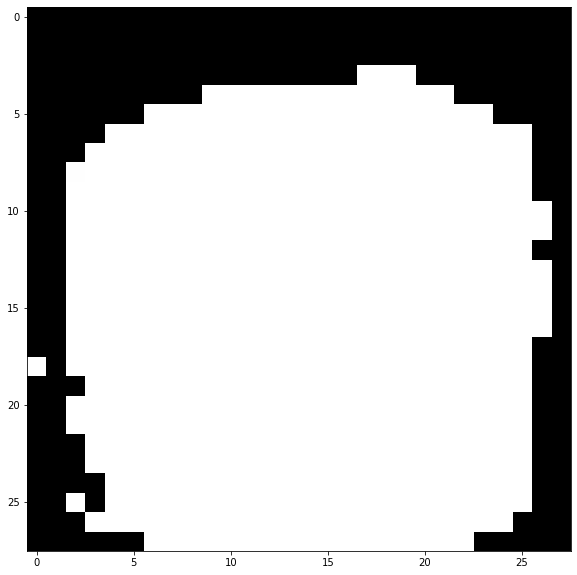

In [0]:
# Calculate the posterior probabilities for each class
posteriorProb = []
for i in range(0,numClasses,1):
    first= -1*((np.power(x_test-means[i],2))/(2*(stds[i]**2)))
    second = -1*(np.log(stds[i]*math.sqrt(2*math.pi)))
    output = first + second
    print("Conditional probability of class "+str(i))
    plt.imshow(np.exp(output[0]).reshape((28,28)),cmap="binary")
    plt.show()
    posteriorProb.append(np.sum(output,axis=1))
posteriorProb = np.array(posteriorProb).T
# Maximum probability of class for test images
classes = np.argmax(posteriorProb,axis=1)


# Part 2
# MNIST with Logistic Regression

## Build a regularized logistic regression classifier, where you use ridge (L2) regularization

In [0]:
# Initialize Lambdas and empty list for Accuracies
lambdas=[0,0.0001,0.001,0.01,0.1,1]
accuracies = []

For lambda = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


28 x 28 image of Weights for digit 0


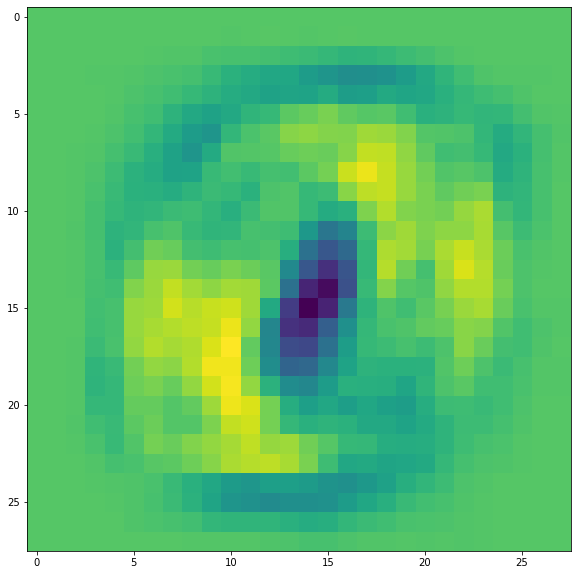

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp



 Confusion Matrix for class0
Predicted  -1.0   0.0
Actual               
-1         8957    63
 1           25   955
28 x 28 image of Weights for digit 1


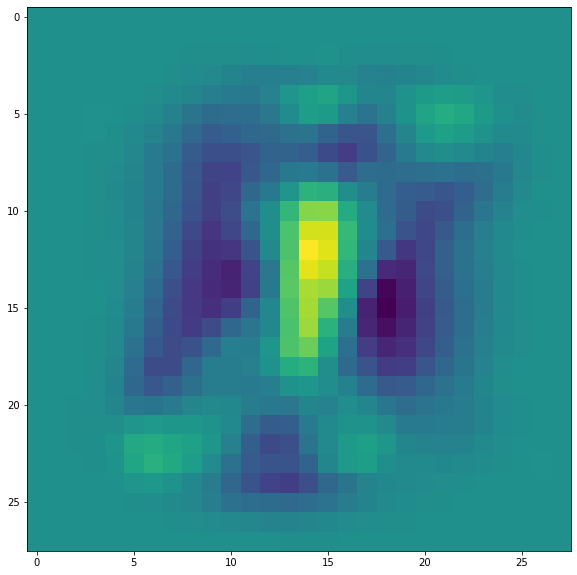


 Confusion Matrix for class1
Predicted  -1.0   1.0
Actual               
-1         8832    33
 1           38  1097
28 x 28 image of Weights for digit 2


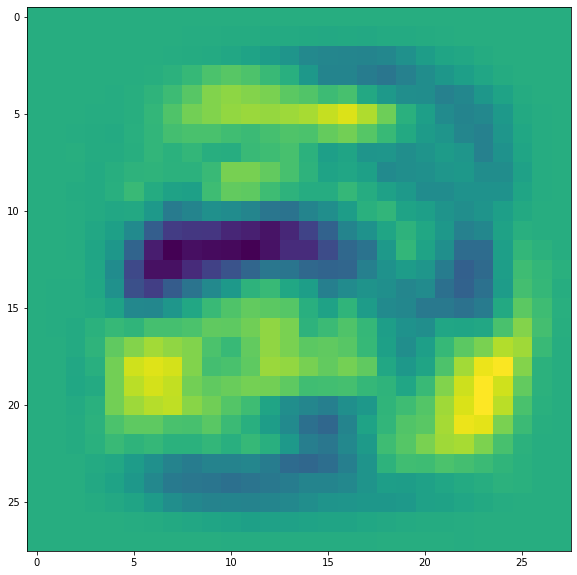


 Confusion Matrix for class2
Predicted  -1.0   2.0
Actual               
-1         8889    79
 1          138   894
28 x 28 image of Weights for digit 3


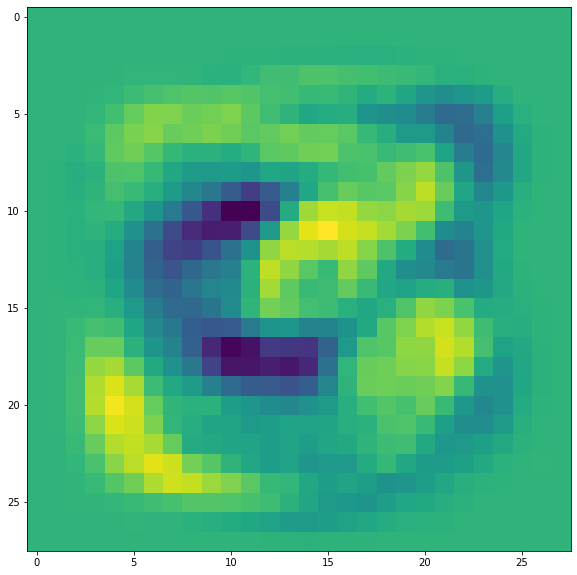


 Confusion Matrix for class3
Predicted  -1.0   3.0
Actual               
-1         8895    95
 1          161   849
28 x 28 image of Weights for digit 4


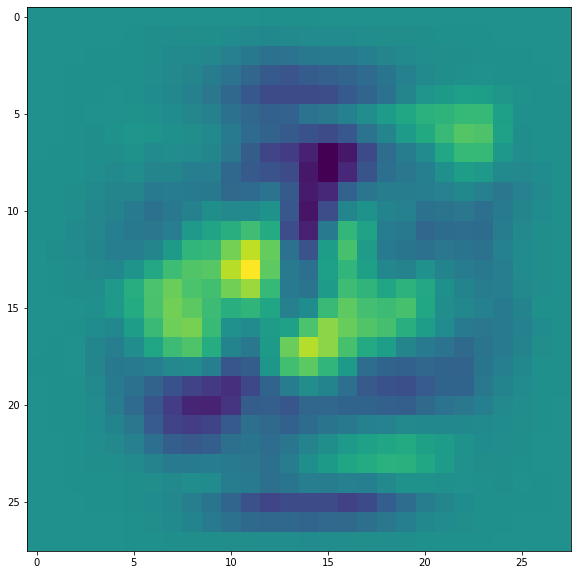


 Confusion Matrix for class4
Predicted  -1.0   4.0
Actual               
-1         8904   114
 1           90   892
28 x 28 image of Weights for digit 5


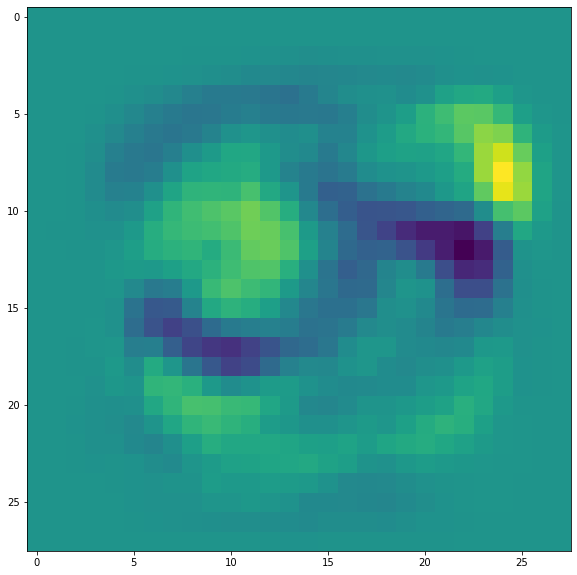


 Confusion Matrix for class5
Predicted  -1.0   5.0
Actual               
-1         8468   640
 1           79   813
28 x 28 image of Weights for digit 6


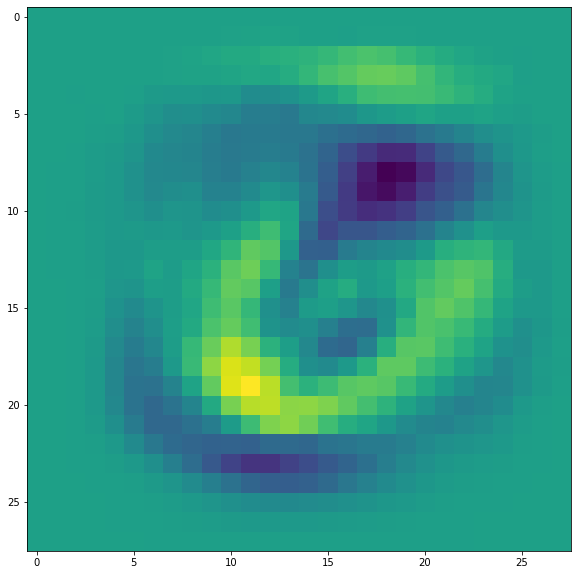


 Confusion Matrix for class6
Predicted  -1.0   6.0
Actual               
-1         8956    86
 1          110   848
28 x 28 image of Weights for digit 7


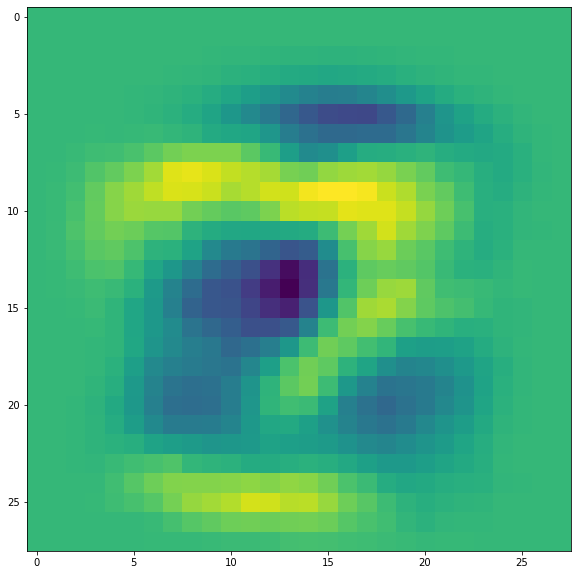


 Confusion Matrix for class7
Predicted  -1.0   7.0
Actual               
-1         8871   101
 1          121   907
28 x 28 image of Weights for digit 8


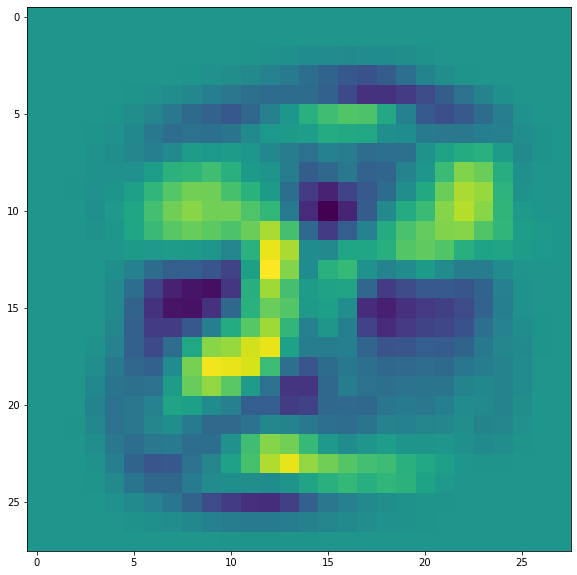


 Confusion Matrix for class8
Predicted  -1.0   8.0
Actual               
-1         8692   334
 1          288   686
28 x 28 image of Weights for digit 9


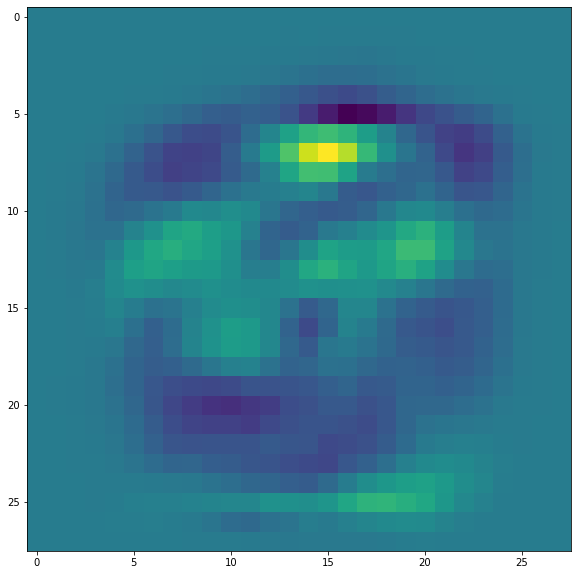


 Confusion Matrix for class9
Predicted  -1.0   9.0
Actual               
-1         8357   634
 1          100   909

Overall Accuracy of the clf: 
86.22999999999999

Confusion Matrix for the Regularized LR:

col_0  0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
row_0                                                   
0      970     0    0    1    0    4    4    1    0    0
1       25  1097    2    1    0    4    3    0    2    1
2       87     7  880    5    7    2    3   11   25    5
3       85     1   15  834    1   52    2    5    7    8
4       38     1    3    3  889    1    6    1    9   31
5       48     5    5   27   14  770    7    0   11    5
6       83     3   15    0   22   62  770    0    3    0
7       62     5   24   14   11   13    1  871    3   24
8      224     4    5    8    9  140    2    5  569    8
9       70     7    2    8   40   45    0   47    5  785

Accuracy for each Digitis:
For lambda = 0.0001
28 x 28 image of Weights for digit 0


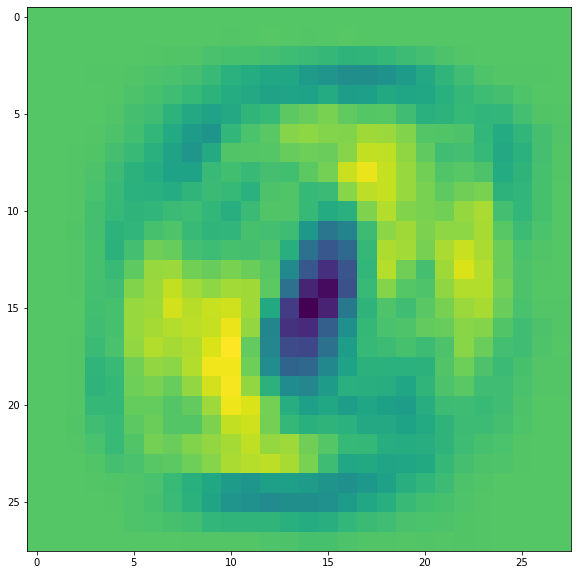


 Confusion Matrix for class0
Predicted  -1.0   0.0
Actual               
-1         8958    62
 1           25   955
28 x 28 image of Weights for digit 1


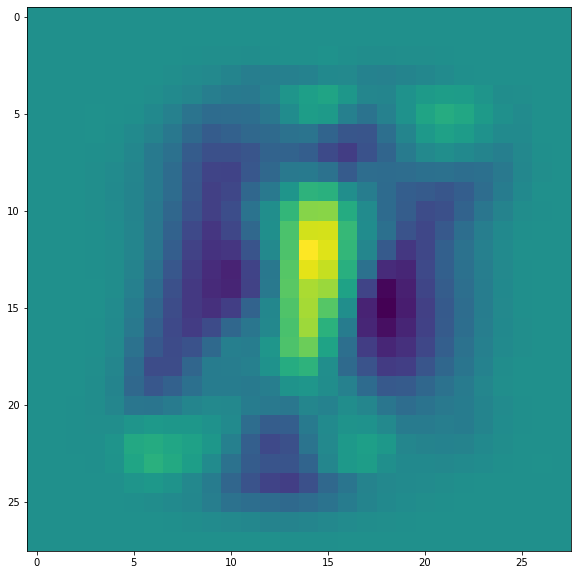


 Confusion Matrix for class1
Predicted  -1.0   1.0
Actual               
-1         8832    33
 1           38  1097
28 x 28 image of Weights for digit 2


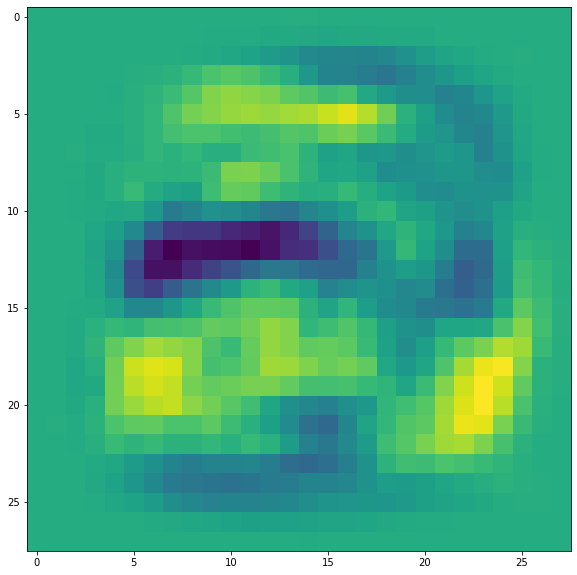


 Confusion Matrix for class2
Predicted  -1.0   2.0
Actual               
-1         8834   134
 1          101   931
28 x 28 image of Weights for digit 3


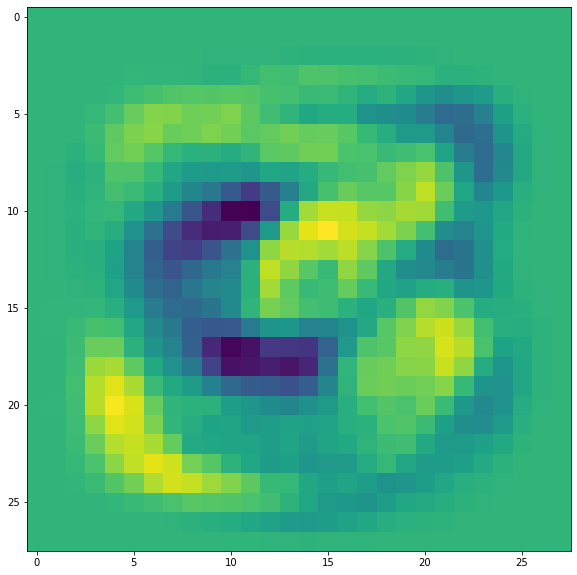


 Confusion Matrix for class3
Predicted  -1.0   3.0
Actual               
-1         8918    72
 1          181   829
28 x 28 image of Weights for digit 4


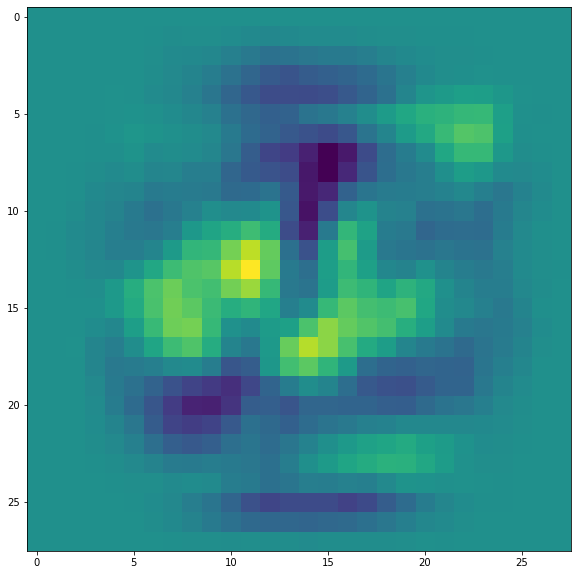


 Confusion Matrix for class4
Predicted  -1.0   4.0
Actual               
-1         8903   115
 1           90   892
28 x 28 image of Weights for digit 5


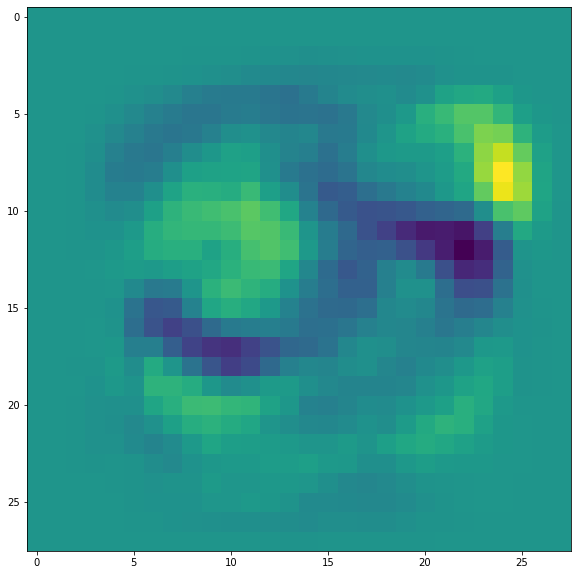


 Confusion Matrix for class5
Predicted  -1.0   5.0
Actual               
-1         9104     4
 1          464   428
28 x 28 image of Weights for digit 6


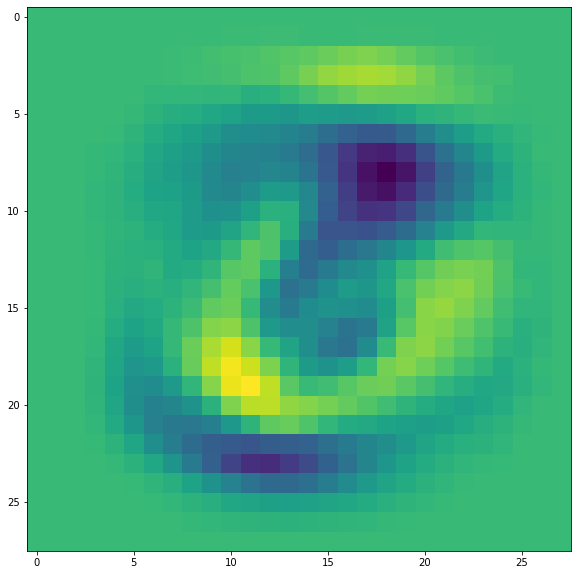


 Confusion Matrix for class6
Predicted  -1.0   6.0
Actual               
-1         9039     3
 1          914    44
28 x 28 image of Weights for digit 7


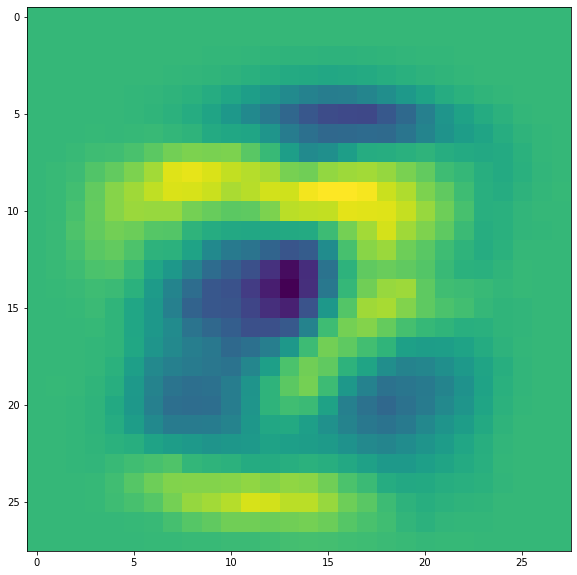


 Confusion Matrix for class7
Predicted  -1.0   7.0
Actual               
-1         8871   101
 1          121   907
28 x 28 image of Weights for digit 8


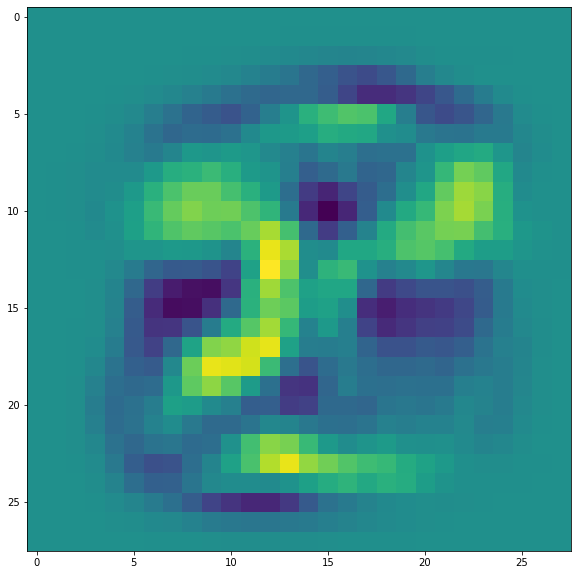


 Confusion Matrix for class8
Predicted  -1.0   8.0
Actual               
-1         7626  1400
 1           85   889
28 x 28 image of Weights for digit 9


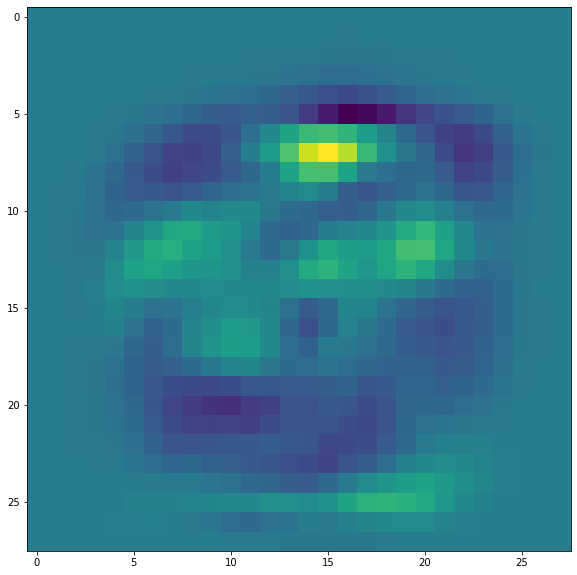


 Confusion Matrix for class9
Predicted  -1.0   9.0
Actual               
-1         8292   699
 1           88   921

Overall Accuracy of the clf: 
64.74

Confusion Matrix for the Regularized LR:

col_0  0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
row_0                                                   
0      975     0    0    1    0    0    0    1    3    0
1       14  1097    4    0    0    1    0    0   19    0
2       51     7  917    4    6    0    0   11   29    7
3      117     1   26  810    1    0    0    6   44    5
4       31     1    8    1  890    0    0    1   22   28
5      255     5    7   23   14  420    0    7  149   12
6      800     3   22    0   21    2   43    0   66    1
7       51     5   38   11   10    0    0  878    6   29
8       74     4    6    6    9    0    0    5  866    4
9       58     7    3    6   41    0    0   50  127  717

Accuracy for each Digitis:
For lambda = 0.001
28 x 28 image of Weights for digit 0


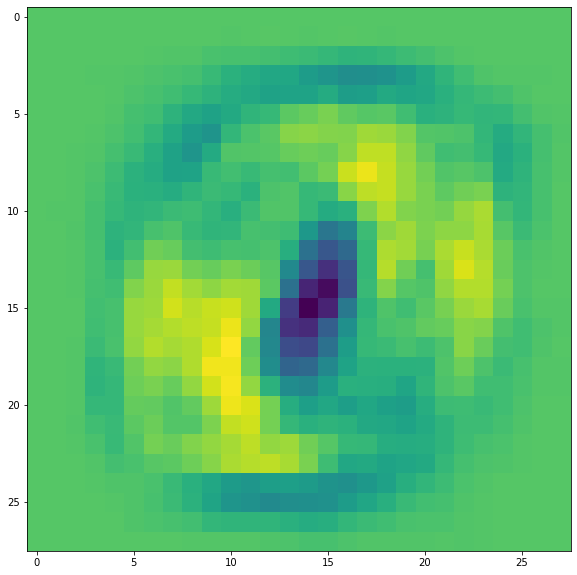


 Confusion Matrix for class0
Predicted  -1.0   0.0
Actual               
-1         8958    62
 1           25   955
28 x 28 image of Weights for digit 1


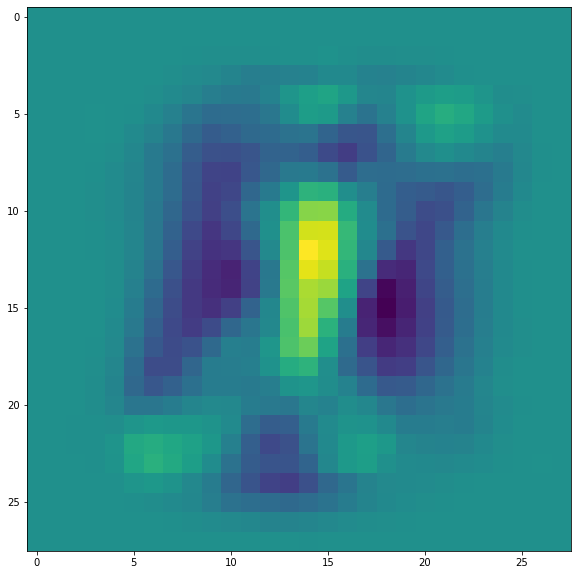


 Confusion Matrix for class1
Predicted  -1.0   1.0
Actual               
-1         8832    33
 1           38  1097
28 x 28 image of Weights for digit 2


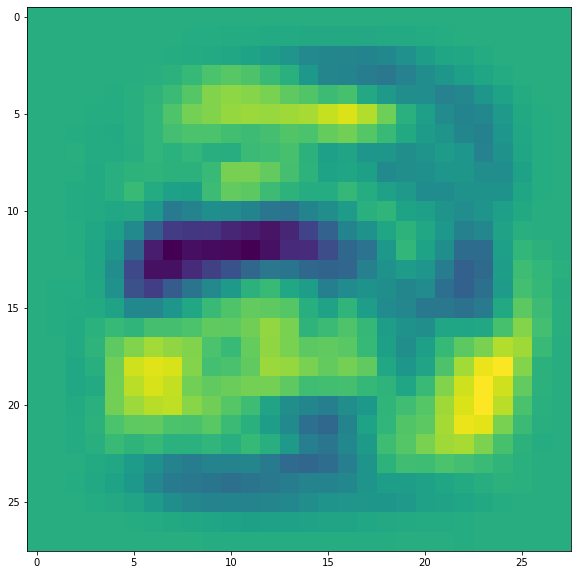


 Confusion Matrix for class2
Predicted  -1.0   2.0
Actual               
-1         8885    83
 1          136   896
28 x 28 image of Weights for digit 3


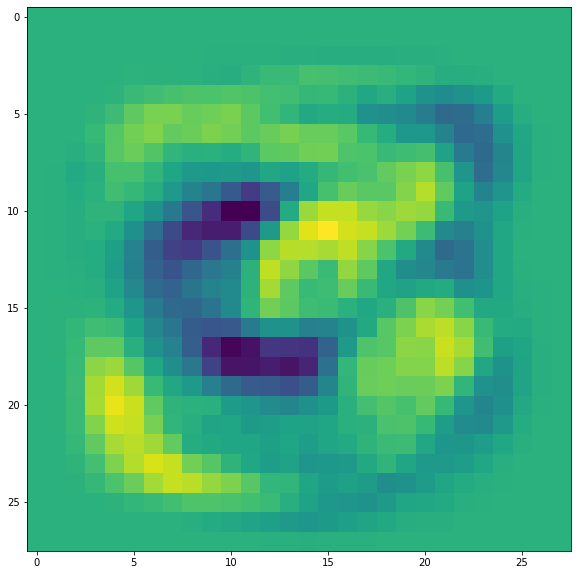


 Confusion Matrix for class3
Predicted  -1.0   3.0
Actual               
-1         8732   258
 1           99   911
28 x 28 image of Weights for digit 4


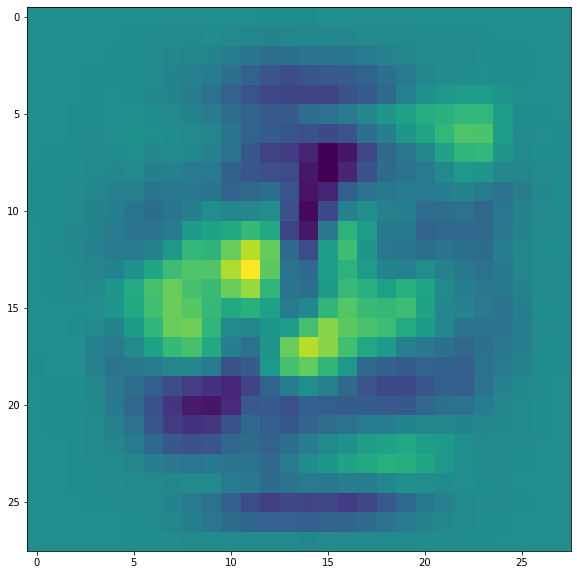


 Confusion Matrix for class4
Predicted  -1.0   4.0
Actual               
-1         8899   119
 1           86   896
28 x 28 image of Weights for digit 5


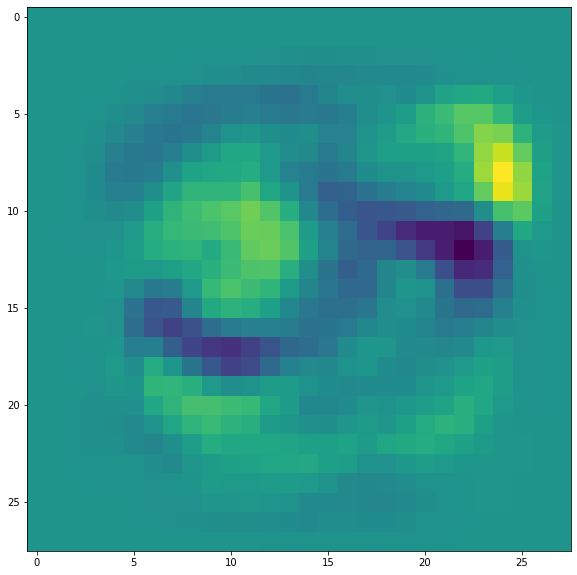


 Confusion Matrix for class5
Predicted  -1.0   5.0
Actual               
-1         8475   633
 1           81   811
28 x 28 image of Weights for digit 6


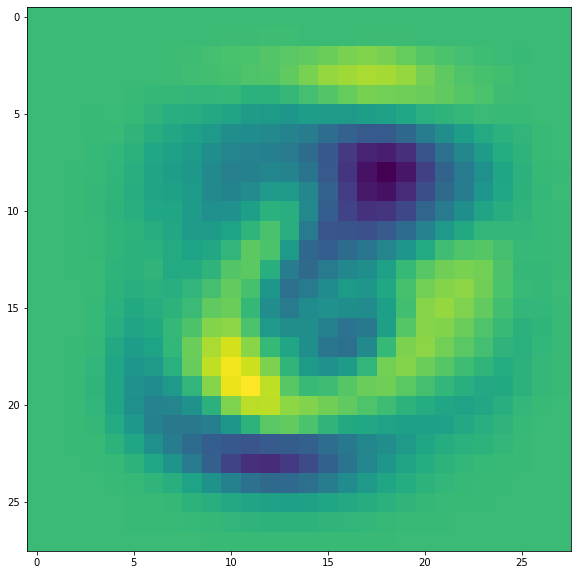


 Confusion Matrix for class6
Predicted  -1.0   6.0
Actual               
-1         9041     1
 1          936    22
28 x 28 image of Weights for digit 7


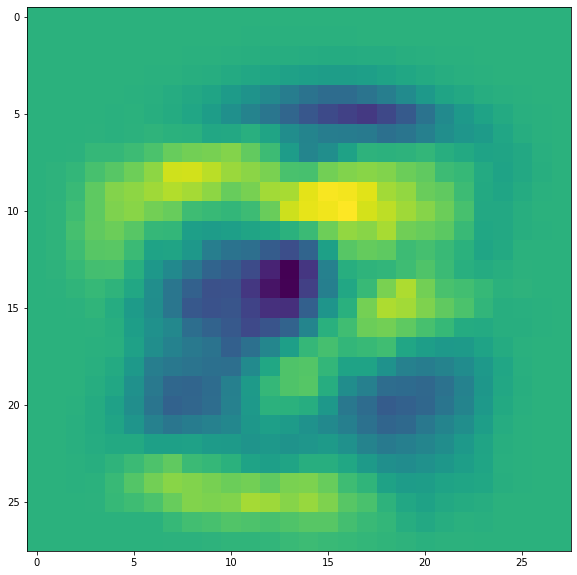


 Confusion Matrix for class7
Predicted  -1.0   7.0
Actual               
-1         8876    96
 1          101   927
28 x 28 image of Weights for digit 8


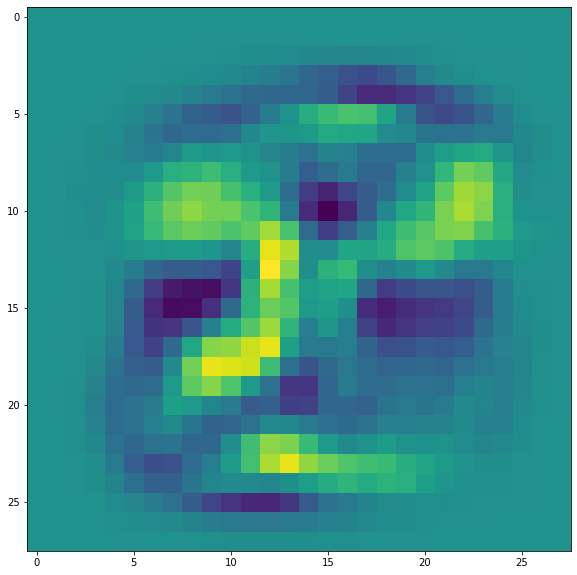


 Confusion Matrix for class8
Predicted  -1.0   8.0
Actual               
-1         8284   742
 1          150   824
28 x 28 image of Weights for digit 9


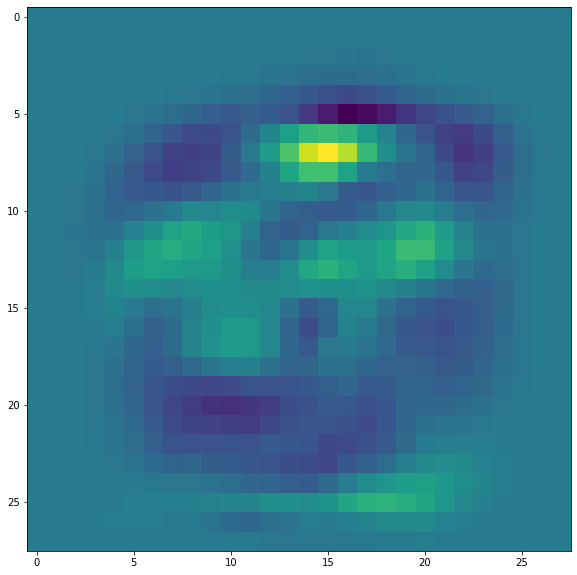


 Confusion Matrix for class9
Predicted  -1.0   9.0
Actual               
-1         8146   845
 1           72   937

Overall Accuracy of the clf: 
68.56

Confusion Matrix for the Regularized LR:

col_0  0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
row_0                                                   
0      974     0    0    1    0    4    0    1    0    0
1       20  1097    2    2    0    4    0    0    9    1
2       71     7  882   10    6    1    0   14   34    7
3       50     1   16  892    0   28    0    7   12    4
4       36     1    3    7  889    1    0    1   14   30
5       50     5    5   61   13  738    0    0   17    3
6      798     3   16    1   23   63   21    0   31    2
7       36     5   26   46   11   13    0  864    4   23
8      104     4    6   19   10  139    0    5  676   11
9       47     7    2   15   44   40    0   27   45  782

Accuracy for each Digitis:
For lambda = 0.01
28 x 28 image of Weights for digit 0


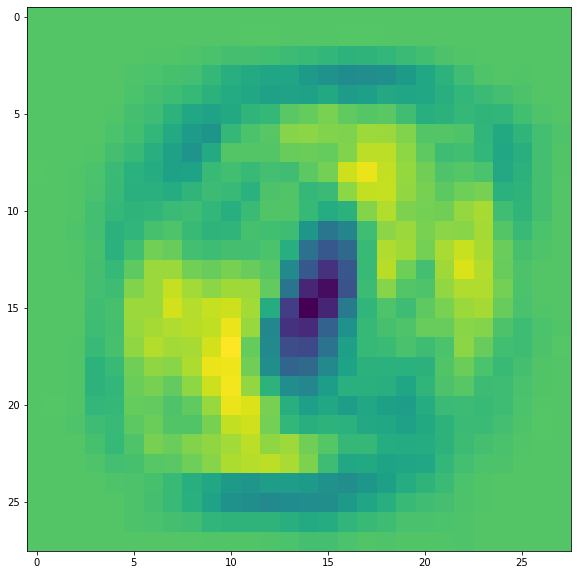


 Confusion Matrix for class0
Predicted  -1.0   0.0
Actual               
-1         8945    75
 1           22   958
28 x 28 image of Weights for digit 1


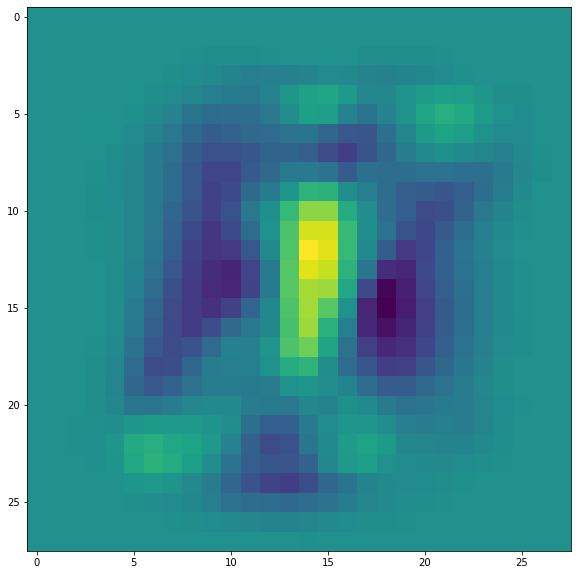


 Confusion Matrix for class1
Predicted  -1.0   1.0
Actual               
-1         8832    33
 1           38  1097
28 x 28 image of Weights for digit 2


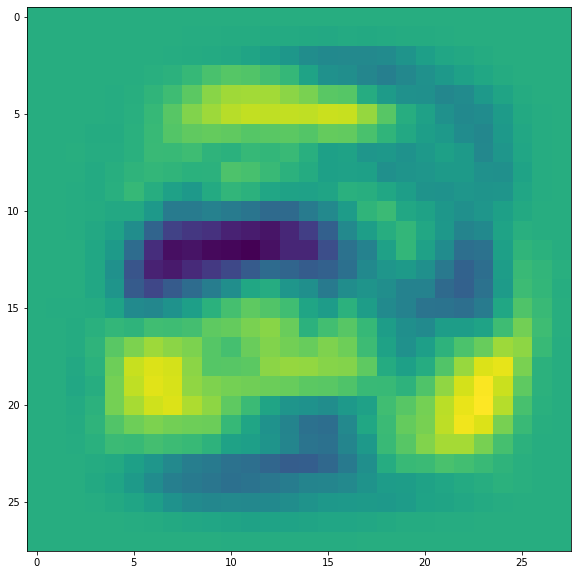


 Confusion Matrix for class2
Predicted  -1.0   2.0
Actual               
-1         8875    93
 1          135   897
28 x 28 image of Weights for digit 3


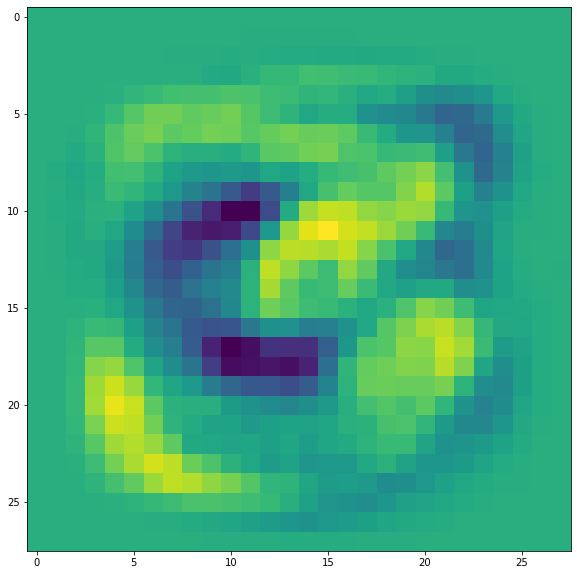


 Confusion Matrix for class3
Predicted  -1.0   3.0
Actual               
-1         8361   629
 1           54   956
28 x 28 image of Weights for digit 4


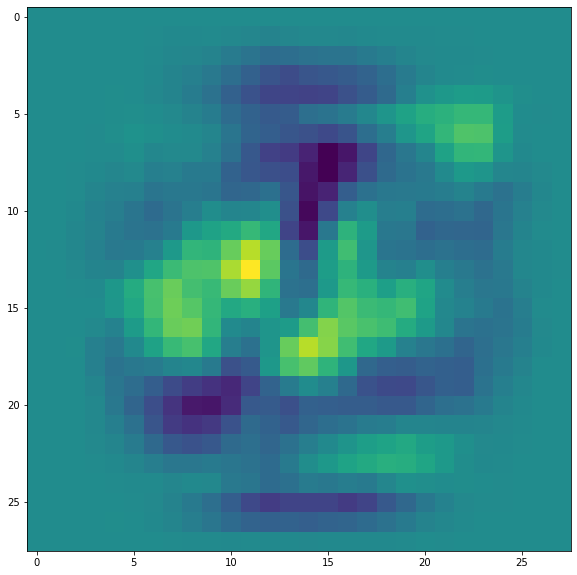


 Confusion Matrix for class4
Predicted  -1.0   4.0
Actual               
-1         8908   110
 1           91   891
28 x 28 image of Weights for digit 5


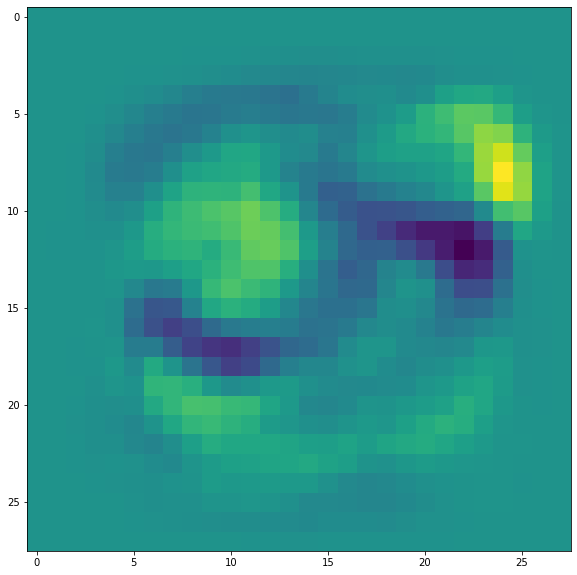


 Confusion Matrix for class5
Predicted  -1.0   5.0
Actual               
-1         8453   655
 1           80   812
28 x 28 image of Weights for digit 6


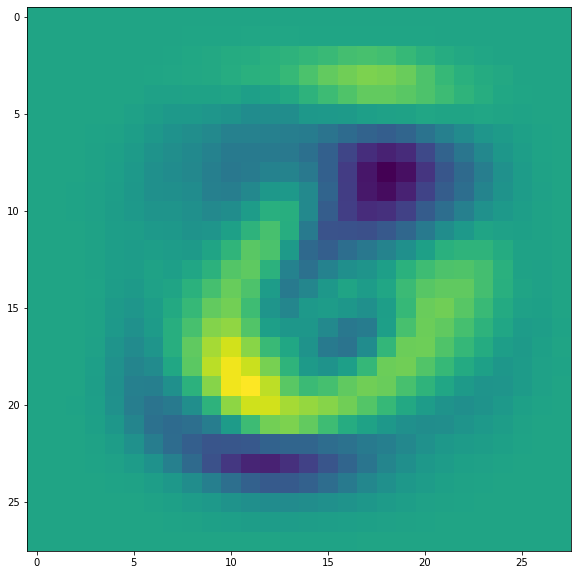


 Confusion Matrix for class6
Predicted  -1.0   6.0
Actual               
-1         8907   135
 1          105   853
28 x 28 image of Weights for digit 7


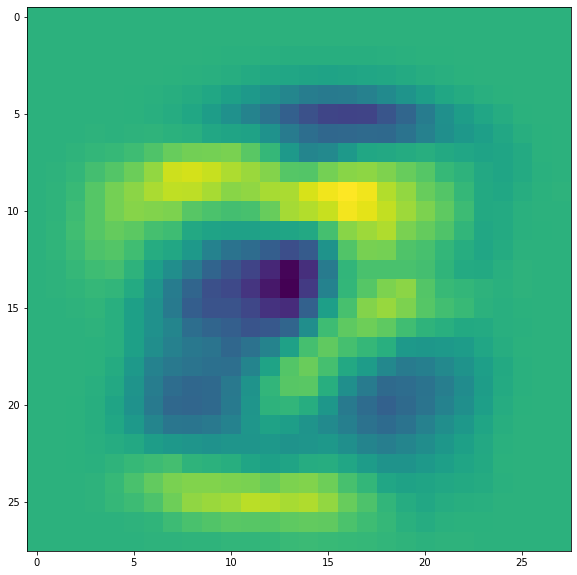


 Confusion Matrix for class7
Predicted  -1.0   7.0
Actual               
-1         8877    95
 1          103   925
28 x 28 image of Weights for digit 8


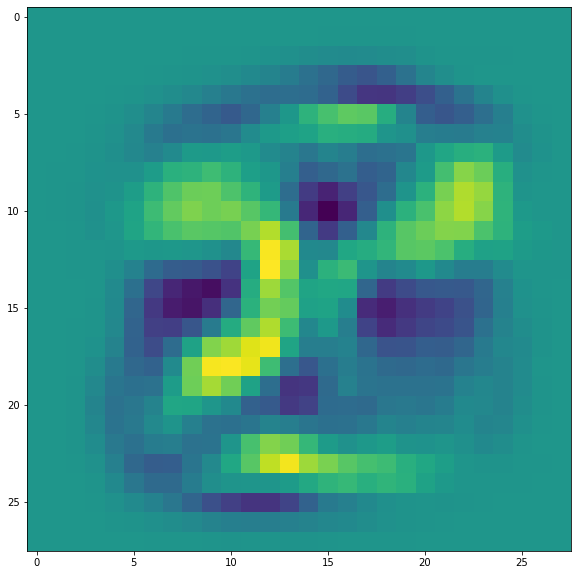


 Confusion Matrix for class8
Predicted  -1.0   8.0
Actual               
-1         8350   676
 1          168   806
28 x 28 image of Weights for digit 9


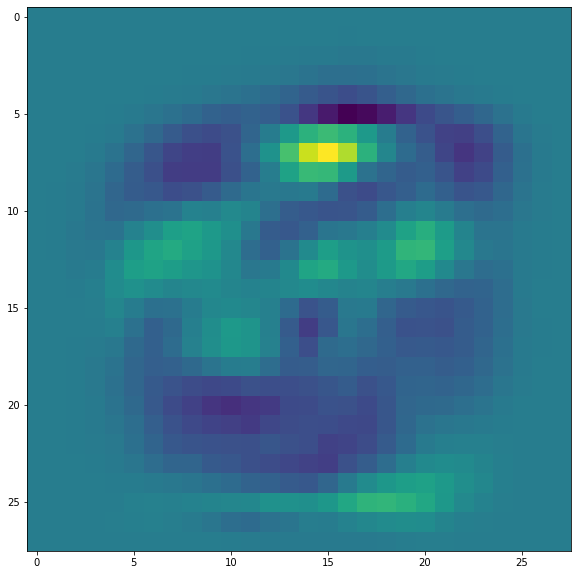


 Confusion Matrix for class9
Predicted  -1.0   9.0
Actual               
-1         8972    19
 1          694   315

Overall Accuracy of the clf: 
75.1

Confusion Matrix for the Regularized LR:

col_0  0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
row_0                                                   
0      968     0    1    2    0    3    5    1    0    0
1       19  1097    2    3    0    4    3    0    7    0
2       66     7  883   20    7    1    8   12   28    0
3       33     1   20  927    0   13    0    6   10    0
4       58     1    6   25  868    1    6    1   14    2
5       49     5    3  133   13  669    6    0   13    1
6       73     3   16    3   22   62  771    0    8    0
7       51     5   24   91    8   13    0  831    3    2
8      120     4    5   58    9  136    3    5  634    0
9      536     7    3   39   39   42    0   37   28  278

Accuracy for each Digitis:
For lambda = 0.1
28 x 28 image of Weights for digit 0


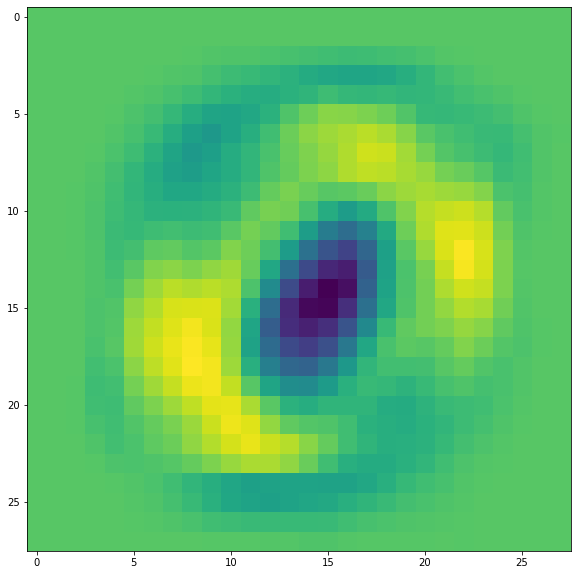


 Confusion Matrix for class0
Predicted  -1.0   0.0
Actual               
-1         8931    89
 1           39   941
28 x 28 image of Weights for digit 1


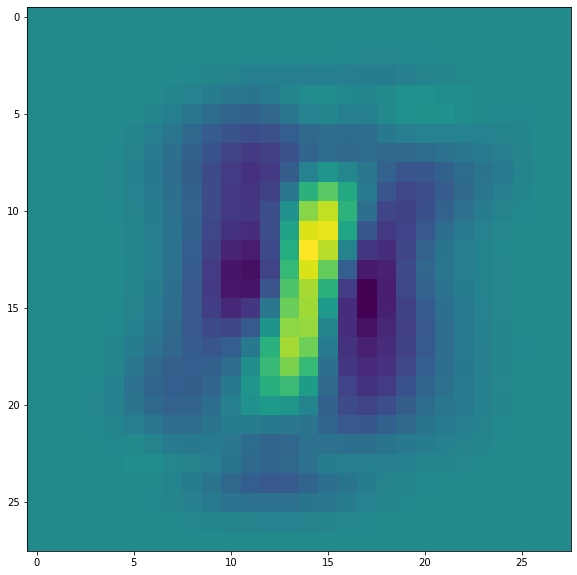


 Confusion Matrix for class1
Predicted  -1.0   1.0
Actual               
-1         8838    27
 1          141   994
28 x 28 image of Weights for digit 2


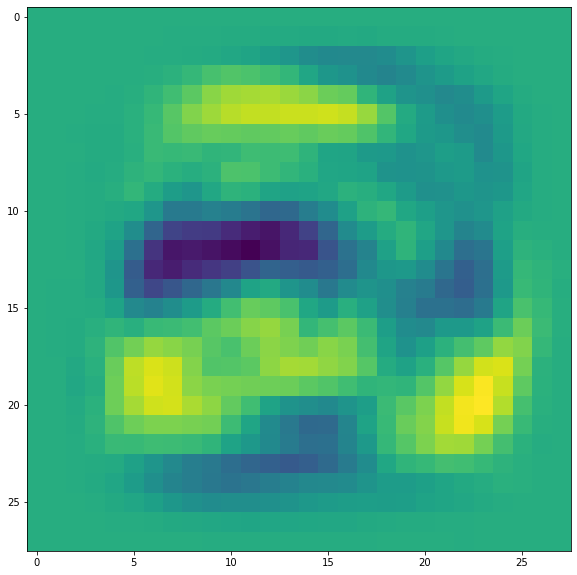


 Confusion Matrix for class2
Predicted  -1.0   2.0
Actual               
-1         8850   118
 1          126   906
28 x 28 image of Weights for digit 3


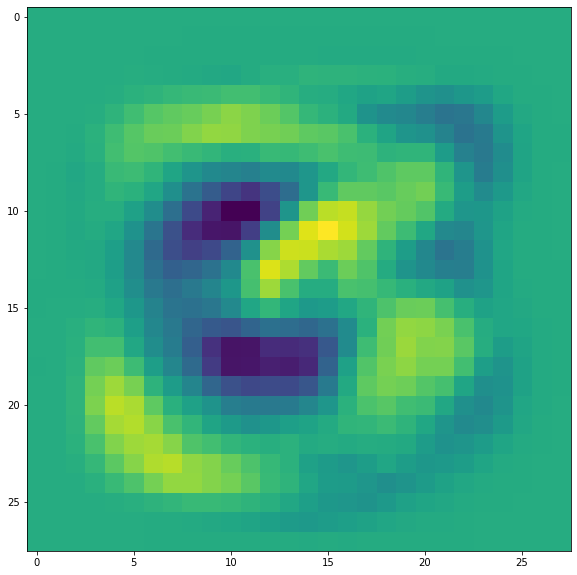


 Confusion Matrix for class3
Predicted  -1.0   3.0
Actual               
-1         8606   384
 1           81   929
28 x 28 image of Weights for digit 4


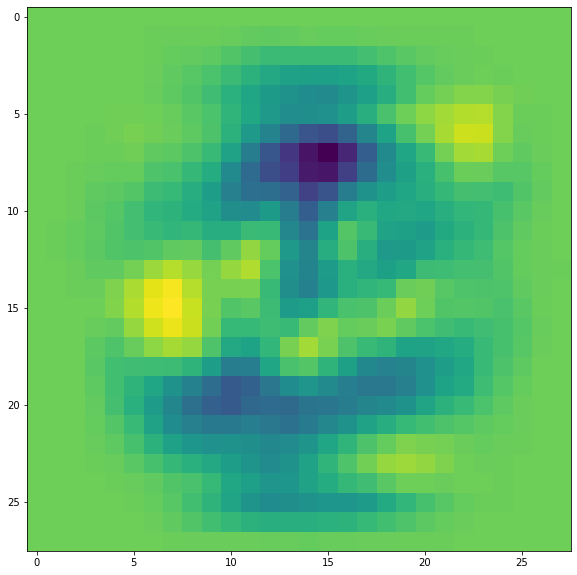


 Confusion Matrix for class4
Predicted  -1.0
Actual         
-1         9018
 1          982
28 x 28 image of Weights for digit 5


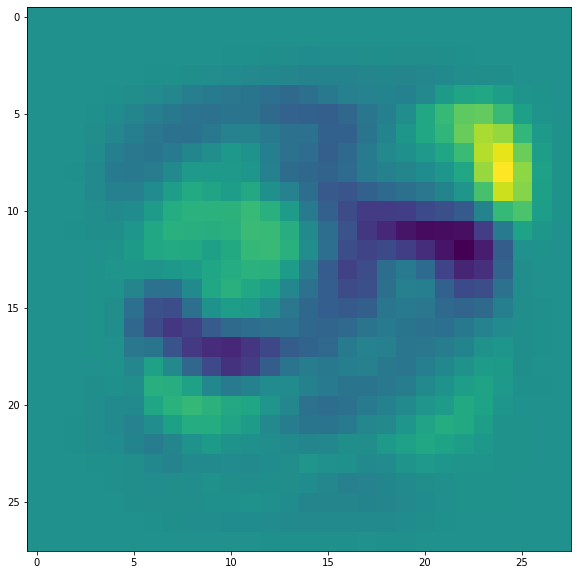


 Confusion Matrix for class5
Predicted  -1.0   5.0
Actual               
-1         9108     0
 1          858    34
28 x 28 image of Weights for digit 6


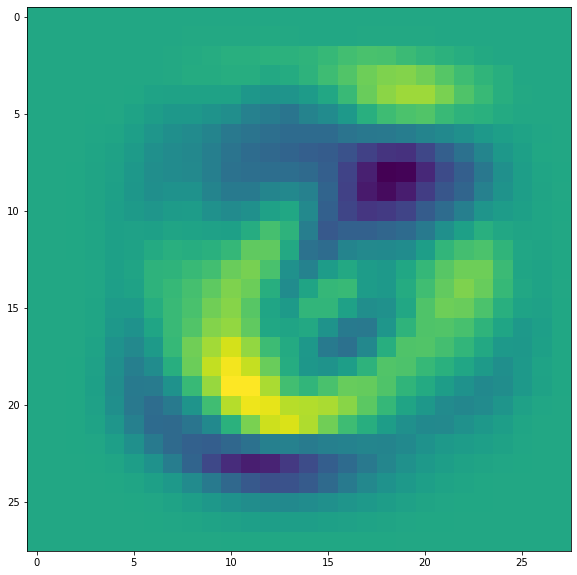


 Confusion Matrix for class6
Predicted  -1.0   6.0
Actual               
-1         8935   107
 1           84   874
28 x 28 image of Weights for digit 7


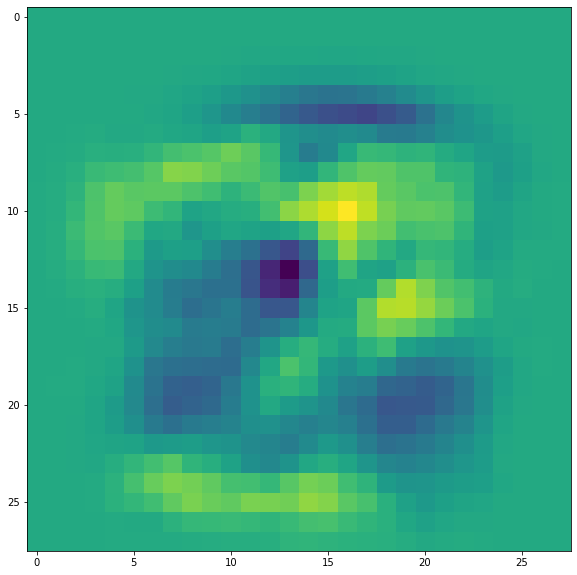


 Confusion Matrix for class7
Predicted  -1.0   7.0
Actual               
-1         8893    79
 1           86   942
28 x 28 image of Weights for digit 8


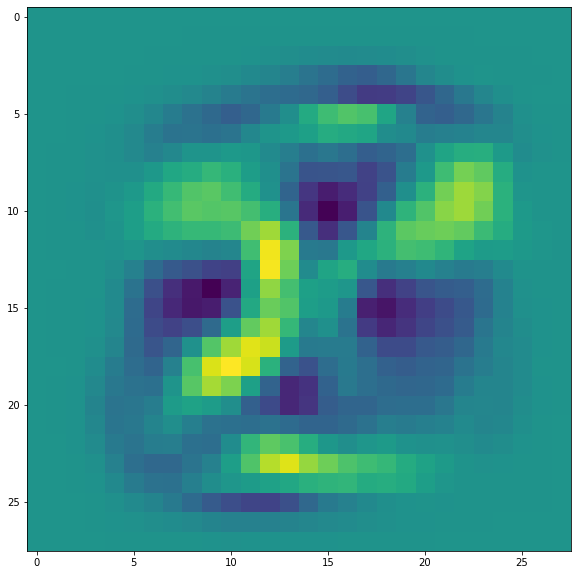


 Confusion Matrix for class8
Predicted  -1.0   8.0
Actual               
-1         8780   246
 1          373   601
28 x 28 image of Weights for digit 9


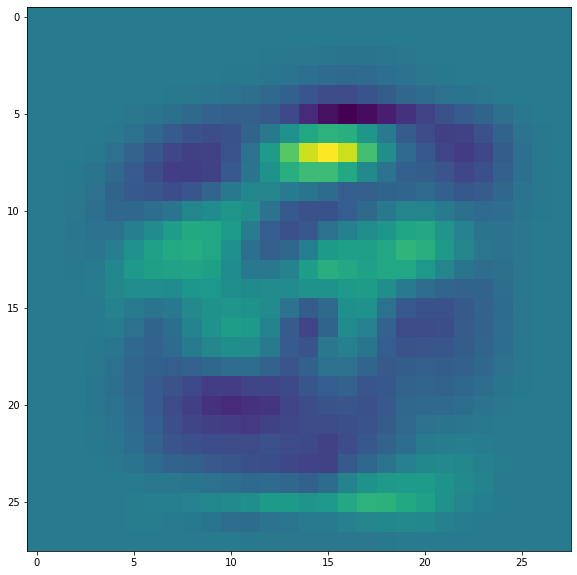


 Confusion Matrix for class9
Predicted  -1.0   9.0
Actual               
-1         8146   845
 1           94   915

Overall Accuracy of the clf: 
67.77

Confusion Matrix for the Regularized LR:

col_0  0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0
row_0                                             
0      969    0    1    3    0    3    0    4    0
1      106  994    6    5    0    3    0   21    0
2       75    9  886   19    0    9    8   19    7
3       58    0   25  906    0    1    6    4   10
4      555    0    7   17    0   11    3   14  375
5      592    2    5  145   31   11   11   60   35
6       95    2   18    2    0  838    1    2    0
7       35   10   37   44    0    0  880    1   21
8      315    1    5   34    0    5    4  589   21
9       71    3    5   19    0    1   25    4  881

Accuracy for each Digitis:
For lambda = 1
28 x 28 image of Weights for digit 0


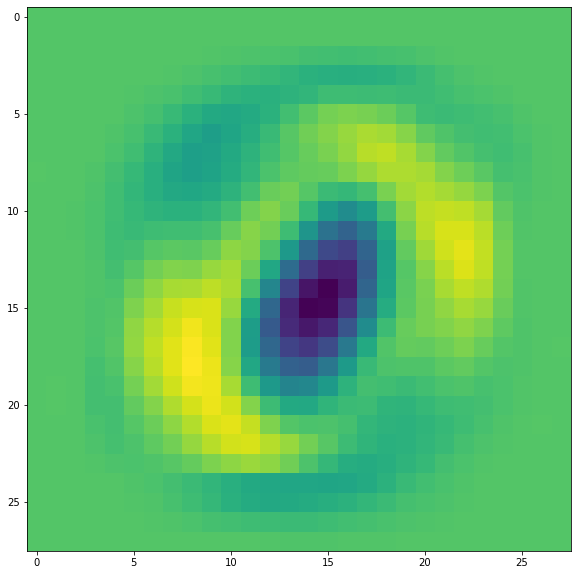


 Confusion Matrix for class0
Predicted  -1.0   0.0
Actual               
-1         8910   110
 1           41   939
28 x 28 image of Weights for digit 1


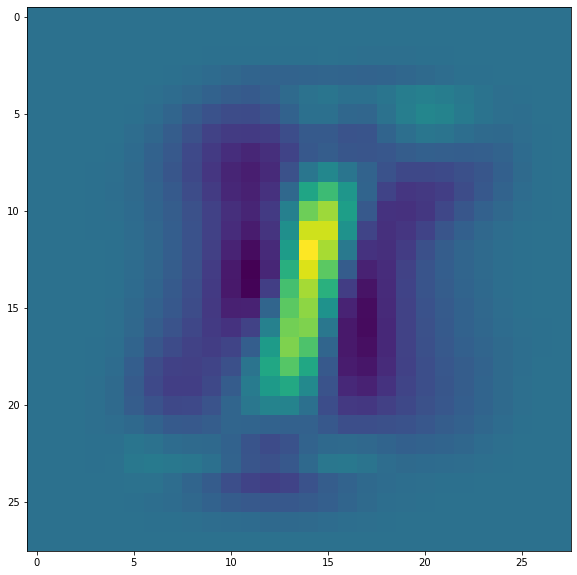


 Confusion Matrix for class1
Predicted  -1.0   1.0
Actual               
-1         8685   180
 1           35  1100
28 x 28 image of Weights for digit 2


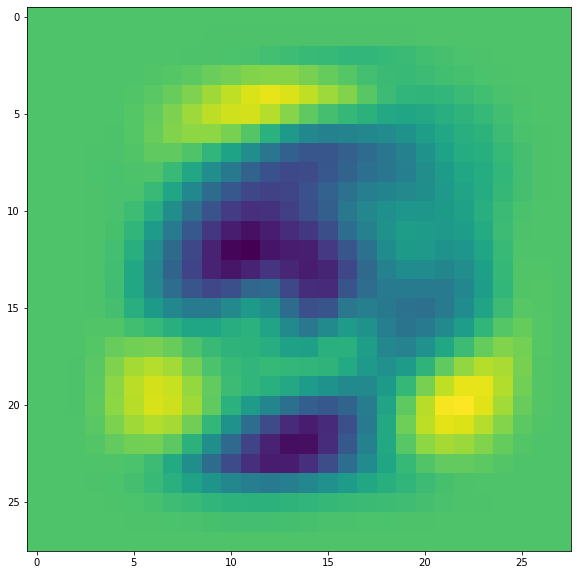


 Confusion Matrix for class2
Predicted  -1.0
Actual         
-1         8968
 1         1032
28 x 28 image of Weights for digit 3


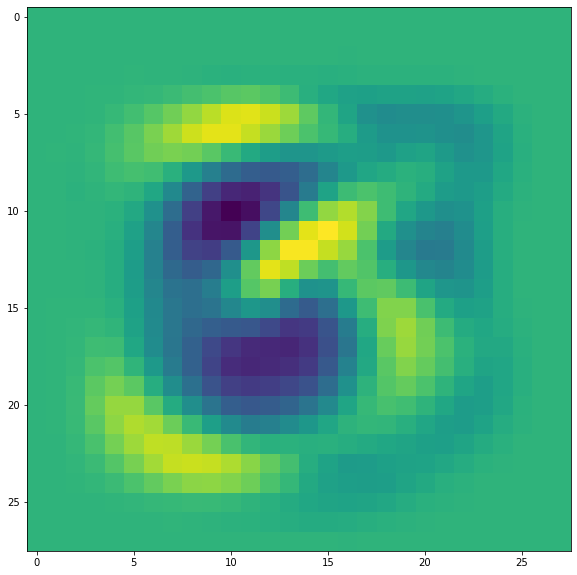


 Confusion Matrix for class3
Predicted  -1.0   3.0
Actual               
-1         8983     7
 1          531   479
28 x 28 image of Weights for digit 4


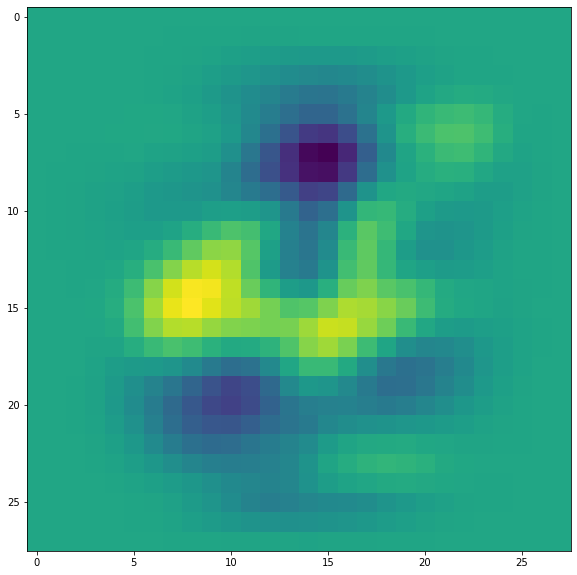


 Confusion Matrix for class4
Predicted  -1.0   4.0
Actual               
-1         8580   438
 1          104   878
28 x 28 image of Weights for digit 5


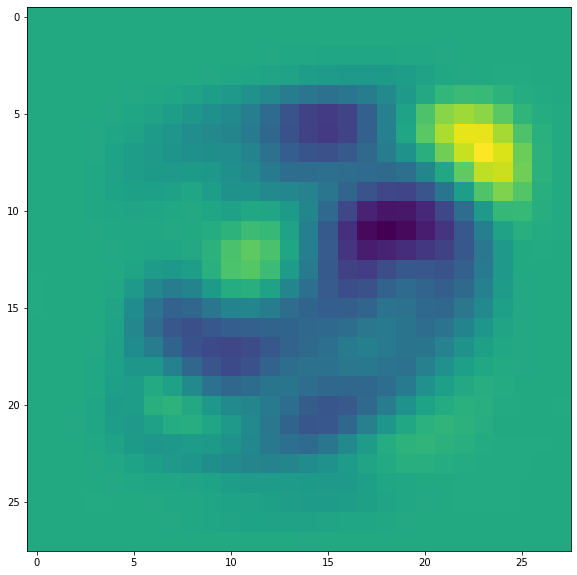


 Confusion Matrix for class5
Predicted  -1.0
Actual         
-1         9108
 1          892
28 x 28 image of Weights for digit 6


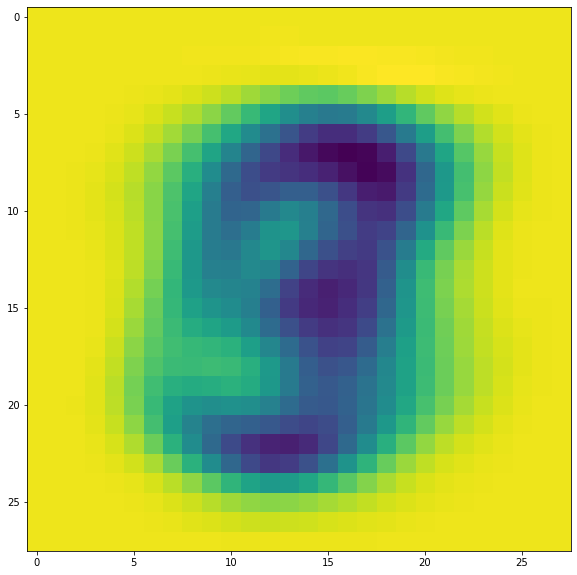


 Confusion Matrix for class6
Predicted  -1.0
Actual         
-1         9042
 1          958
28 x 28 image of Weights for digit 7


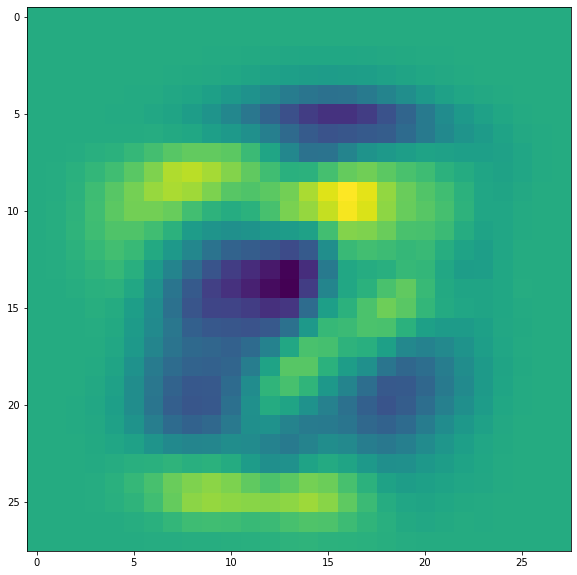


 Confusion Matrix for class7
Predicted  -1.0   7.0
Actual               
-1         8953    19
 1          214   814
28 x 28 image of Weights for digit 8


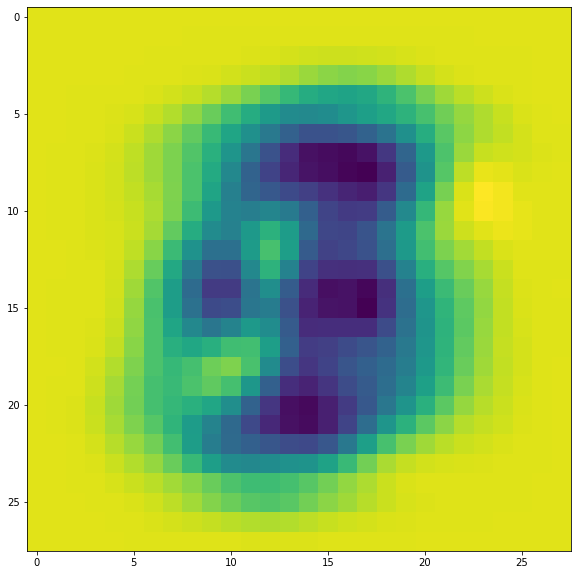


 Confusion Matrix for class8
Predicted  -1.0
Actual         
-1         9026
 1          974
28 x 28 image of Weights for digit 9


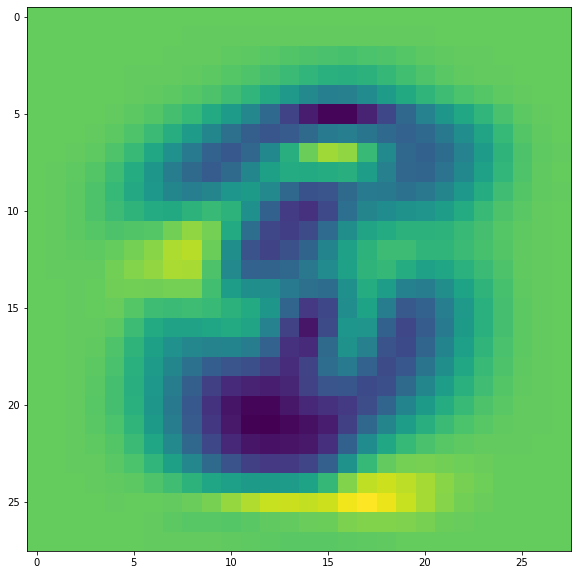


 Confusion Matrix for class9
Predicted  -1.0
Actual         
-1         8991
 1         1009

Overall Accuracy of the clf: 
38.68

Confusion Matrix for the Regularized LR:

col_0  0.0   1.0  3.0  4.0  7.0
row_0                          
0      979     0    0    0    1
1       34  1100    0    1    0
2      918    73    1   35    5
3      525     3  476    1    5
4       97    10    0  875    0
5      842    14    6   27    3
6      903     5    0   50    0
7      168    44    0   36  780
8      946    20    0    7    1
9      718    11    0  277    3

Accuracy for each Digitis:


In [0]:
for l in lambdas:
  print( "For lambda = " +str(l))

  # Initialize empty lists and error value
  err = 0
  digit_acc = []
  pred_class = []
  pred_overall = []

  # Add bias term as column of 1's to train and test
  X_train_bias = np.hstack((np.ones(shape=(60000,1)),X_train))
  X_test_bias = np.hstack((np.ones(shape=(10000,1)),X_test))

  # 1 v All clf
  for i in range(10):
    # Initialize w 
    w_new = np.zeros(shape=(785,1))

    # Change class labels to +1/-1 and reshape for train
    Y_train_binary = np.copy(Y_train)
    Y_train_binary[Y_train != i] = -1
    Y_train_binary[np.logical_and(Y_train == i, Y_train != -1)] = 1
    Y_train_binary = Y_train_binary.reshape((60000,1))

     # # Change class labels to +1/-1 for test
    Y_test_binary = np.copy(Y_test)
    Y_test_binary[Y_test != i] = -1
    Y_test_binary[np.logical_and(Y_test == i, y_test != -1)] = 1
    
    # YX terms
    B = np.multiply(Y_train_binary, X_train_bias)

    # Gradient Descent updates
    for y in range(100):
      Z = np.dot(B,w_new)
      A = 1 / (1 + np.exp(-Z))
      w_new -= (0.1)*(-np.dot(B.T,(1-A)) + l*w_new)
    # Print images of GD
    print("28 x 28 image of Weights for digit " + str(i))
    plt.imshow(w_new[1:].reshape(28,28))
    plt.show()

    # Predict and set to correct class
    pred = (1/(1+np.exp(-1*np.dot(X_test_bias,w_new))))
    pred[pred != 1] = -1
    pred[pred == 1] = pred[pred == 1]*i

    # Store predicted classes
    pred_class.append(pred[:,0])

    # Confusion Matrix for each Class
    print("\n Confusion Matrix for class" +str(i))
    actual = pd.Series(Y_test_binary, name="Actual")
    predicted = pd.Series(pred.T[0], name="Predicted")
    print(pd.crosstab(actual,predicted))

    # Total Error
    err += abs(np.sum(y_test == i)-np.sum((1/(1+np.exp(-1*np.dot(X_test_bias,w_new))))))

    # Digit,Accuracy
    digit_acc.append((i,abs(np.sum(Y_test == i)-abs(np.sum(Y_test == i)-np.sum((1/(1+np.exp(-1*np.dot(X_test_bias,w_new)))))))/np.sum(Y_test == i)*100))

  # Predictions for all classes
  All = np.array(pred_class).T

  # Overall Accuracy
  print("\nOverall Accuracy of the clf: ")
  total_acc = ((len(Y_test)-err)/len(X_test)) * 100
  print(total_acc)

  # Append to Accuracies list
  accuracies.append(total_acc)

  # Check class based on probabilities
  for img in range(len(X_test_bias)):
    if np.all(All[img] == -1):
      pred_overall.append(0.0)
    else:
      pred_overall.append(Counter(All[img][All[img] != -1]).most_common(1)[0][0])

  # CM for ALL CLF
  print("\nConfusion Matrix for the Regularized LR:\n")
  print(pd.crosstab(Y_test,np.array(pred_overall).T))

  # Accuracy for each Digit
  print("\nAccuracy for each Digitis:")
  acc_df = pd.DataFrame(digit_acc,columns = ['Digit','Accuracy'])
  print(acc_df)

# plt.plot(lambdas,accuracies)
# plt.xlabel("Lambda Value")
# plt.ylabel("Accuracy")
# plt.show()

# Do these images provide any insight to how this classifier works?